## 后面的MRG和IG没有检查水平结构是否正确

改进的Kelvin波可视化程序

[1] 生成高质量快照...
✓ 快照已保存: kelvin_wave_improved_snapshot.png
✓ 快照已保存: kelvin_wave_improved_snapshot.png


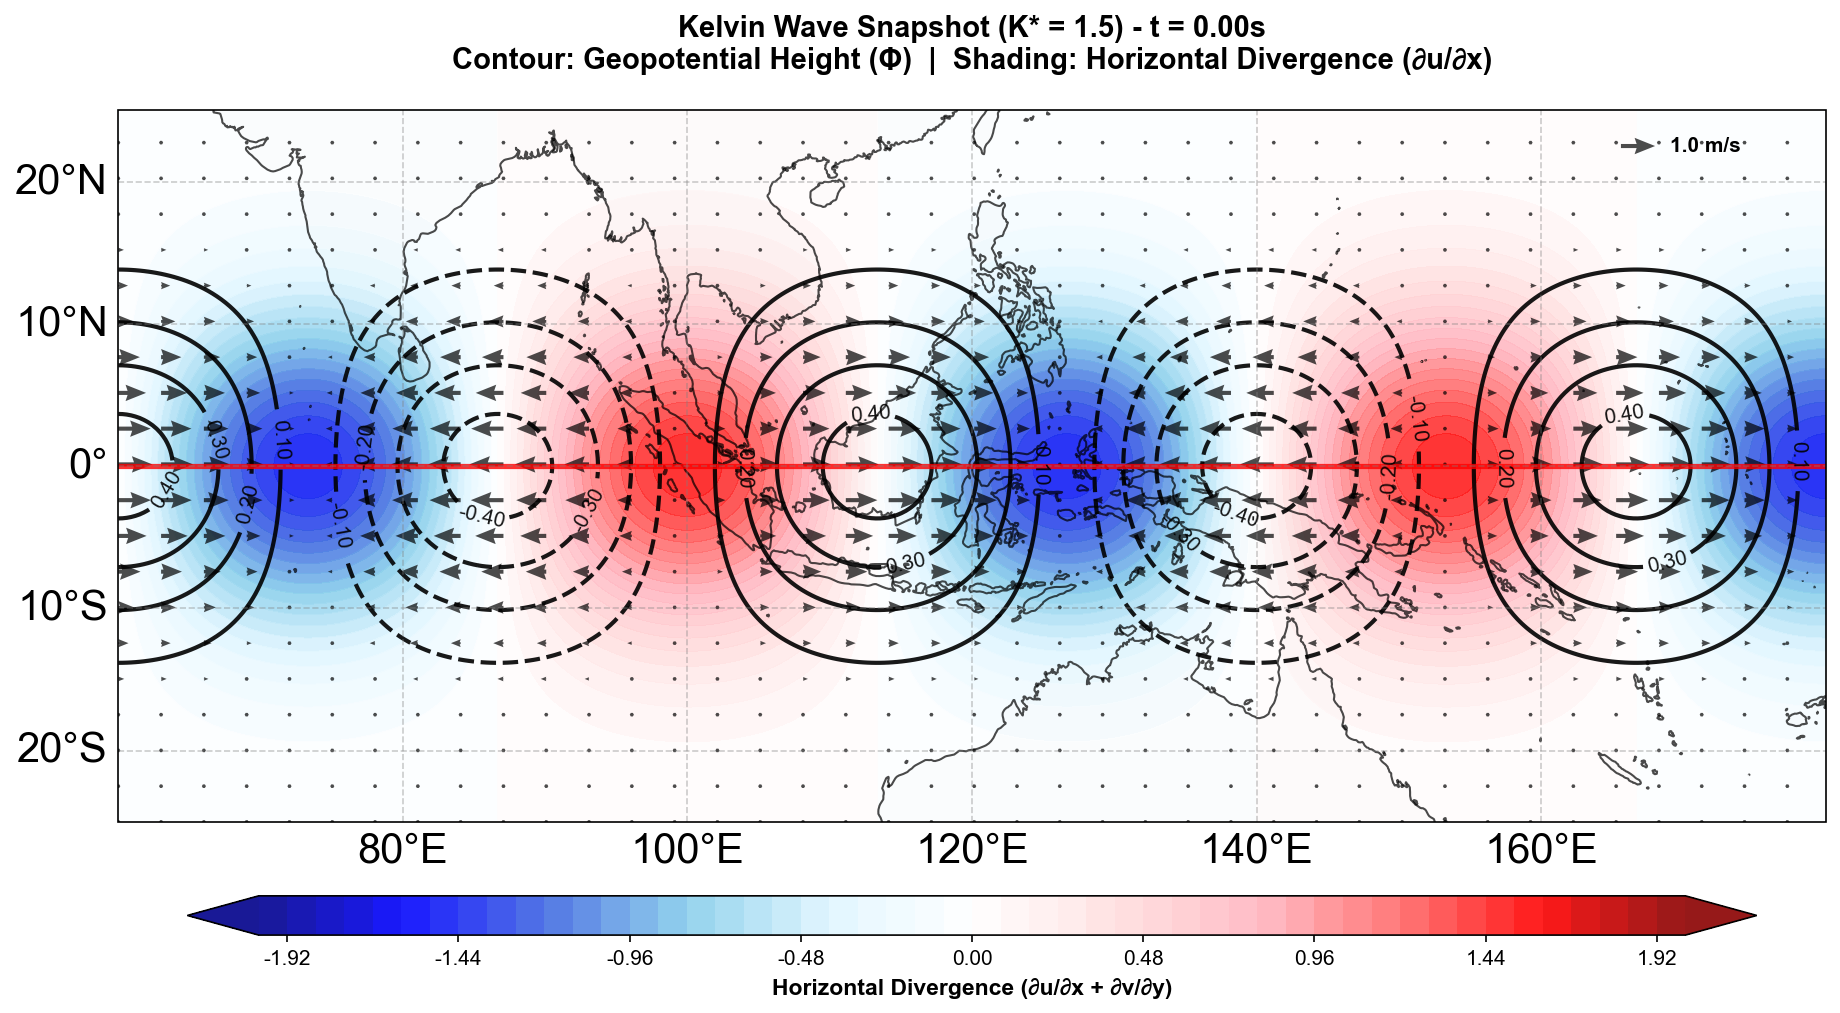


[2] 生成动画...
预计算 50 帧数据...
开始渲染动画...
保存动画到 kelvin_wave_improved.gif...
开始渲染动画...
保存动画到 kelvin_wave_improved.gif...
✓ 成功保存!

完成!
✓ 成功保存!

完成!


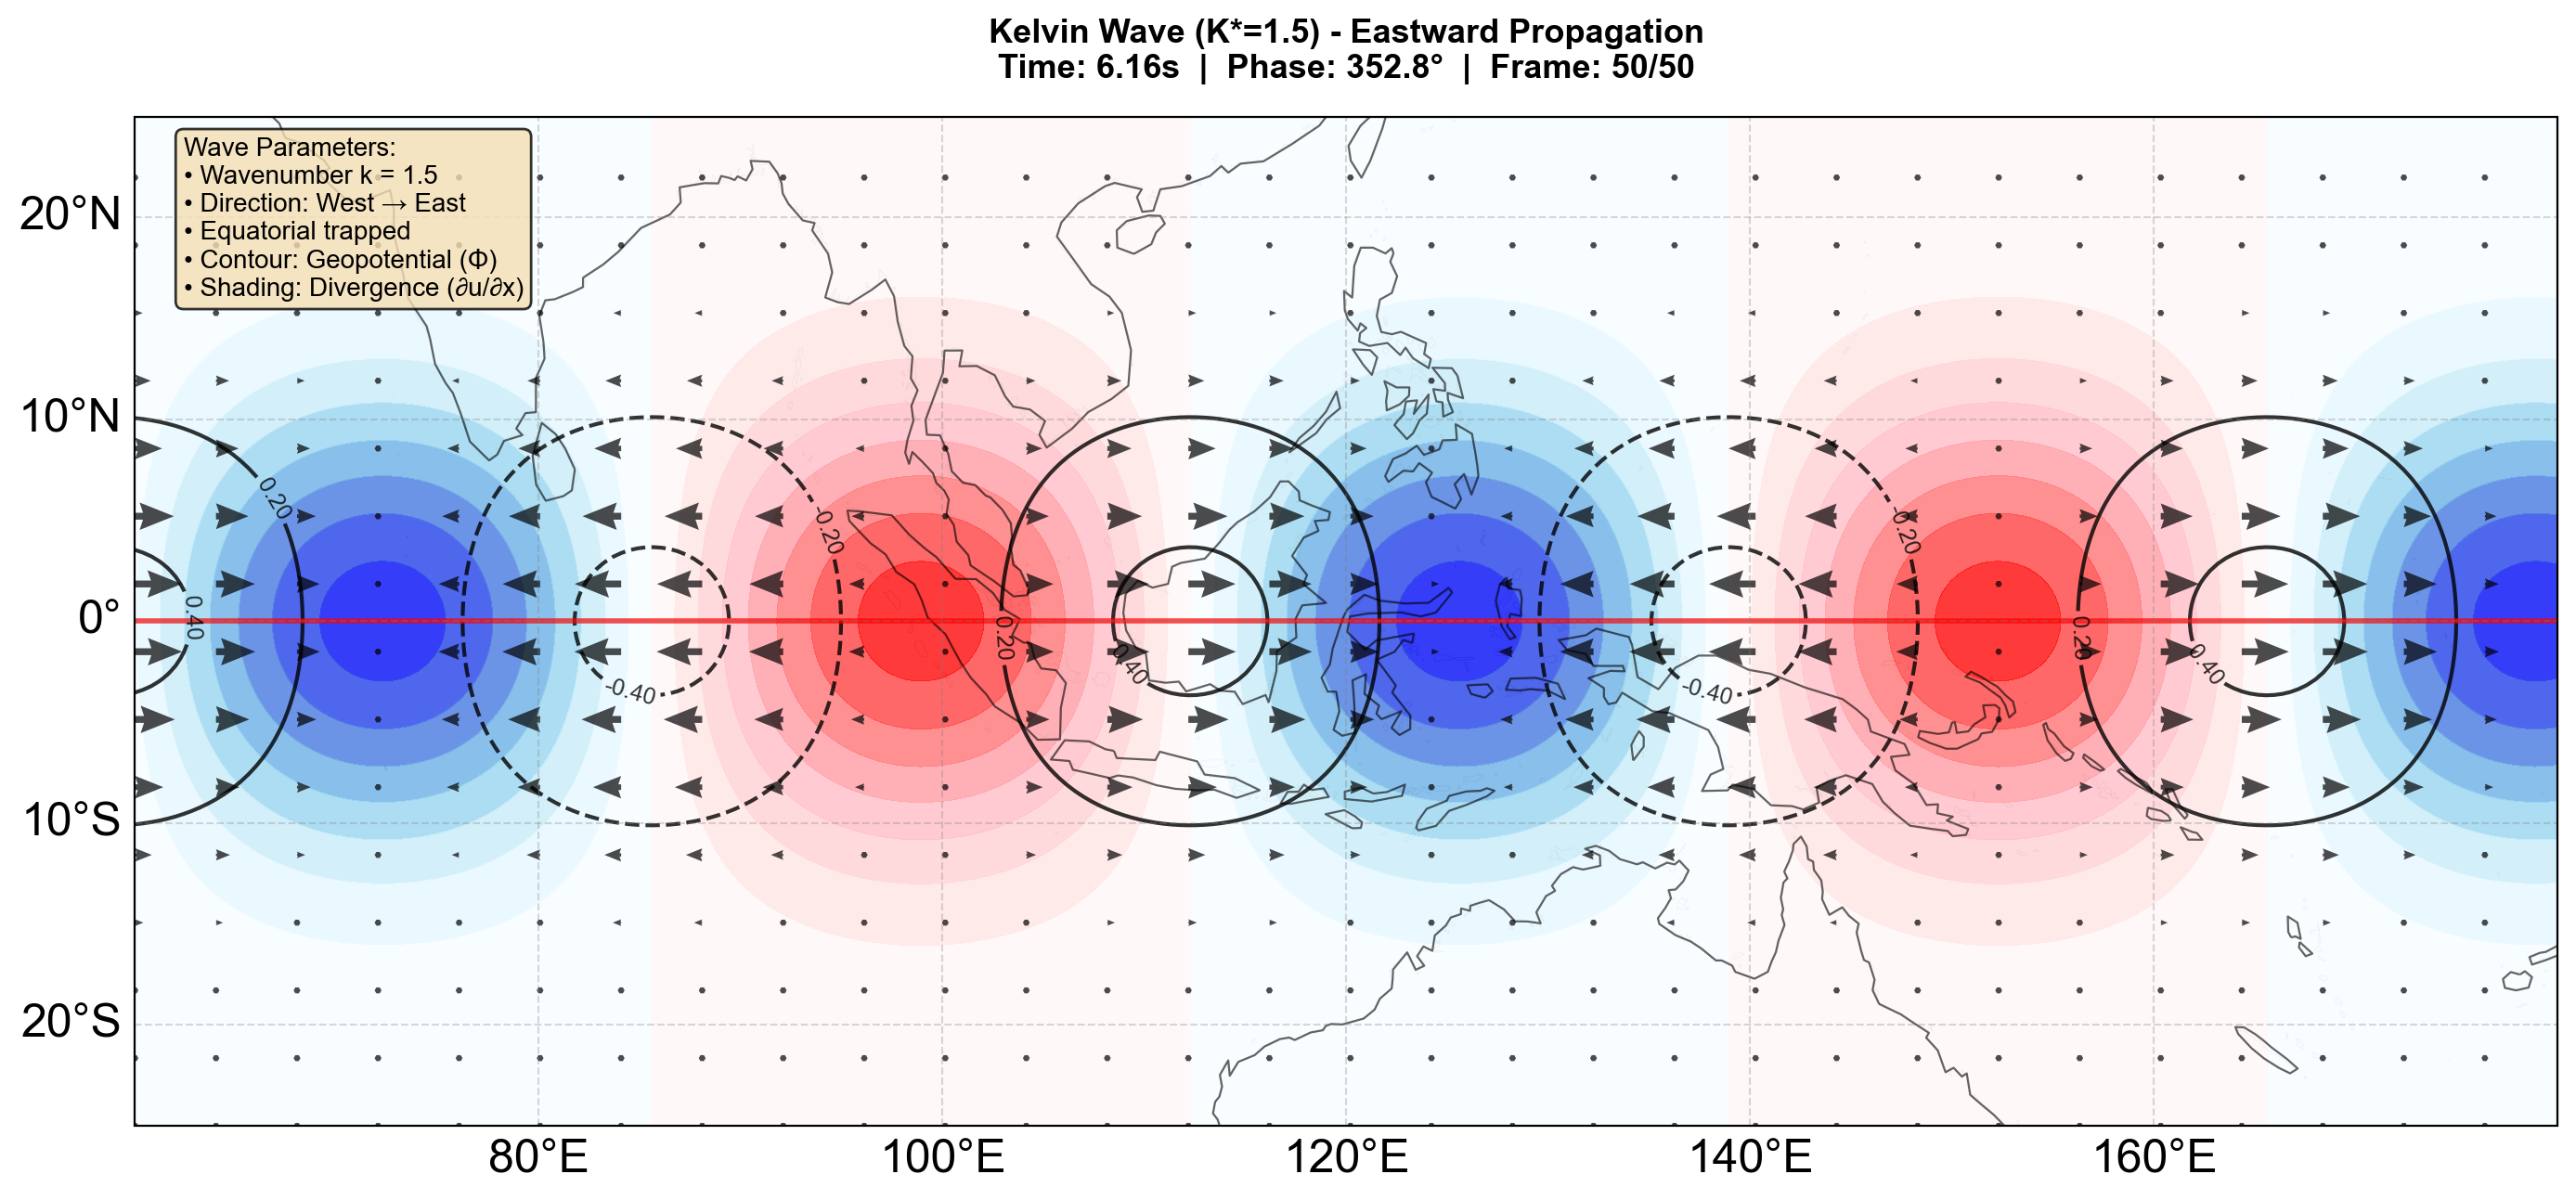

In [6]:
# -*- coding: utf-8 -*-
"""
改进的Kelvin波东传动画 - 更美观的视觉效果
@author: xianpuji
@email: xianpuji@hhu.edu.cn
"""
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Circle

plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def create_improved_colormap():
    """创建改进的红-白-蓝配色"""
    colors = ['#00008B', '#0000FF', '#4169E1', '#87CEEB', '#E0F6FF',
              '#FFFFFF', 
              '#FFE0E0', '#FFB6C1', '#FF6B6B', '#FF0000', '#8B0000']
    return LinearSegmentedColormap.from_list('improved_bwr', colors, N=256)

def kelvin_wave_field(x, y, t, k=1.0, omega=1.0, c=1.0, y_scale=7.0):
    """
    计算理想化的Kelvin波场
    
    参数:
        x, y: 空间坐标 (经度和纬度方向)
        t: 时间
        k: 波数
        omega: 频率
        c: 波速
        y_scale: 纬度衰减尺度
    
    返回:
        u, v: 速度分量
        Phi: 位势高度
        div: 水平散度 (∂u/∂x + ∂v/∂y)
    """
    # Kelvin波的纬度结构: 高斯衰减
    y_structure = np.exp(-0.5 * (y / y_scale)**2)
    
    # 东传的波动相位
    phase = k * x - omega * t
    
    # 纬向速度 (u) - 主要分量
    u = y_structure * np.cos(phase)
    
    # 经向速度 (v) - Kelvin波特征: v=0
    v = np.zeros_like(u)
    
    # 位势高度场 (Phi)
    Phi = (c / k) * y_structure * np.cos(phase)
    
    # 水平散度: div = ∂u/∂x + ∂v/∂y
    # ∂u/∂x = -k * y_structure * sin(phase)
    # ∂v/∂y = 0 (因为 v = 0)
    div = -k * y_structure * np.sin(phase)
    
    return u, v, Phi, div

def create_kelvin_animation_improved(
        lon_range=(60, 180),
        lat_range=(-30, 30),
        nx=300, ny=150,
        total_frames=100,
        wave_number=2,
        save_path=None):
    """
    创建改进的Kelvin波动画
    """
    
    # 空间网格
    lon = np.linspace(lon_range[0], lon_range[1], nx)
    lat = np.linspace(lat_range[0], lat_range[1], ny)
    LON, LAT = np.meshgrid(lon, lat)
    
    # 物理空间坐标 (归一化)
    x_phys = np.linspace(0, 2*np.pi*wave_number, nx)
    y_phys = np.linspace(lat_range[0], lat_range[1], ny)
    X, Y = np.meshgrid(x_phys, y_phys)
    
    # 波动参数
    k = wave_number  # 波数
    omega = 1.0      # 频率
    c = omega / k    # 波速
    
    # 配色方案
    cmap = create_improved_colormap()
    
    # 预计算所有帧
    print(f"预计算 {total_frames} 帧数据...")
    frames_data = []
    
    for frame in range(total_frames):
        t = frame * 2 * np.pi / total_frames
        u, v, Phi, div = kelvin_wave_field(X, Y, t, k=k, omega=omega, c=c, y_scale=8.0)
        frames_data.append({'u': u, 'v': v, 'Phi': Phi, 'div': div, 't': t})
    
    print("开始渲染动画...")
    
    # 创建图形
    # plt.switch_backend('Agg')
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(15, 9), dpi=200)
    ax = fig.add_subplot(111, projection=projection)
    
    # 调整子图位置以确保标签可见
    fig.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.08)
    
    def animate(frame):
        ax.clear()
        
        data = frames_data[frame]
        u = data['u']
        v = data['v']
        Phi = data['Phi']
        div = data['div']  # 水平散度
        
        # 地图背景
        ax.coastlines(resolution='110m', linewidth=0.8, color='black', alpha=0.6)
        ax.add_feature(cfeature.LAND, facecolor='white', alpha=0.3, 
                      edgecolor='black', linewidth=0.3)
        
        # 绘制水平散度填色图 (改为散度)
        levels_fill = np.linspace(-2, 2, 21)
        cf = ax.contourf(LON, LAT, div, levels=levels_fill, 
                        cmap=cmap, extend='both', 
                        transform=projection, alpha=0.85)
        
        # 叠加位势高度等值线 (保持位势高度)
        levels_contour = np.linspace(-1.0, 1.0, 11)
        cs_solid = ax.contour(LON, LAT, Phi, levels=levels_contour[levels_contour > 0], 
                             colors='black', linewidths=1.5, 
                             transform=projection, alpha=0.8)
        cs_dashed = ax.contour(LON, LAT, Phi, levels=levels_contour[levels_contour < 0], 
                              colors='black', linewidths=1.5, linestyles='dashed',
                              transform=projection, alpha=0.8)
        
        # 标注等值线数值
        ax.clabel(cs_solid, inline=True, fontsize=9, fmt='%.2f')
        ax.clabel(cs_dashed, inline=True, fontsize=9, fmt='%.2f')
        
        # 风矢量 (显示速度场)
        step = 10
        Q = ax.quiver(LON[::step, ::step], LAT[::step, ::step],
                    u[::step, ::step], v[::step, ::step],
                    scale=50, 
                    #  scale_units='inches', width=0.003,
                    color='k', alpha=0.7, transform=projection,
                    headwidth=4, headlength=5,)
        # step_quiver = 10
        # Q = ax.quiver(LON[::step_quiver, ::step_quiver], 
        #              LAT[::step_quiver, ::step_quiver],
        #              u[::step_quiver, ::step_quiver], 
        #              v[::step_quiver, ::step_quiver],
        #              scale=8, 
        #             #  scale_units='inches', width=0.003,
        #              color='black', alpha=0.7, transform=projection,
        #              headwidth=4, headlength=5, headaxislength=4)
        
        # 赤道标注
        ax.plot([lon_range[0], lon_range[1]], [0, 0], color='red', linewidth=2, 
                linestyle='-', alpha=0.7, transform=projection)
       
        
        # 设置地图范围和网格
        ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], 
                     crs=projection)
        
        gl = ax.gridlines(draw_labels=True, linewidth=0.75, 
                         color='gray', alpha=0.3, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 18}
        gl.ylabel_style = {'size': 18}
        
        # 标题
        phase_deg = (frame / total_frames) * 360
        ax.set_title(
            f'Kelvin Wave (K*={wave_number}) - Eastward Propagation\n'
            f'Time: {data["t"]:.2f}s  |  Phase: {phase_deg:.1f}°  |  Frame: {frame+1}/{total_frames}',
            fontsize=13, fontweight='bold', pad=15
        )
        
        # 添加说明文本
        info_text = (
            f'Wave Parameters:\n'
            f'• Wavenumber k = {wave_number}\n'
            f'• Direction: West → East\n'
            f'• Equatorial trapped\n'
            f'• Contour: Geopotential (Φ)\n'
            f'• Shading: Divergence (∂u/∂x)'
        )
        ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        return [cf, cs_solid, cs_dashed, Q]
    
    # 创建动画
    anim = animation.FuncAnimation(fig, animate, frames=total_frames,
                                  interval=100, blit=False, repeat=True)
    
    # 保存动画
    if save_path:
        print(f"保存动画到 {save_path}...")
        try:
            anim.save(save_path, writer='pillow', fps=10, dpi=100)
            print(f"✓ 成功保存!")
        except Exception as e:
            print(f"✗ 保存失败: {e}")
            print("尝试逐帧保存...")
            save_frame_by_frame(frames_data, projection, lon_range, lat_range, 
                              LON, LAT, save_path, wave_number, total_frames, cmap)
    
    return fig, anim

def save_frame_by_frame(frames_data, projection, lon_range, lat_range, 
                       LON, LAT, save_path, wave_number, total_frames, cmap):
    """逐帧保存方法 (备用)"""
    from PIL import Image
    import tempfile
    import os
    import shutil
    
    temp_dir = tempfile.mkdtemp()
    print(f"临时目录: {temp_dir}")
    
    images = []
    
    for idx, data in enumerate(frames_data):
        print(f"渲染第 {idx+1}/{total_frames} 帧", end='\r')
        
        fig_temp = plt.figure(figsize=(18, 8), dpi=80)
        ax_temp = fig_temp.add_subplot(111, projection=projection)
        
        u, v, Phi, div = data['u'], data['v'], data['Phi'], data['div']
        
        # 背景
        ax_temp.coastlines(resolution='110m', linewidth=0.8, color='black', alpha=0.6)
        ax_temp.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
        
        # 填色 - 改为散度
        levels_fill = np.linspace(-2, 2, 21)
        ax_temp.contourf(LON, LAT, div, levels=levels_fill, cmap=cmap, 
                        extend='both', transform=projection, alpha=0.85)
        
        # 等值线 - 保持位势高度
        levels_contour = np.linspace(-1.0, 1.0, 11)
        cs_pos = ax_temp.contour(LON, LAT, Phi, 
                                levels=levels_contour[levels_contour > 0],
                                colors='black', linewidths=1.5, 
                                transform=projection, alpha=0.8)
        cs_neg = ax_temp.contour(LON, LAT, Phi,
                                levels=levels_contour[levels_contour < 0],
                                colors='black', linewidths=1.5, 
                                linestyles='dashed',
                                transform=projection, alpha=0.8)
        
        ax_temp.clabel(cs_pos, inline=True, fontsize=8, fmt='%.2f')
        ax_temp.clabel(cs_neg, inline=True, fontsize=8, fmt='%.2f')
        
        # 风矢量
        step_quiver = 30
        ax_temp.quiver(LON[::step_quiver, ::step_quiver],
                      LAT[::step_quiver, ::step_quiver],
                      u[::step_quiver, ::step_quiver],
                      v[::step_quiver, ::step_quiver],
                      scale=8,
                    #   scale_units='inches', width=0.003,
                      color='black', alpha=0.7, transform=projection,
                      headwidth=4, headlength=5, headaxislength=4)
        
        # 赤道
        ax_temp.plot([lon_range[0], lon_range[1]], [0, 0], color='red', 
                    linewidth=2, alpha=0.7, transform=projection)
        
        ax_temp.set_extent([lon_range[0], lon_range[1], 
                           lat_range[0], lat_range[1]], crs=projection)
        
        gl = ax_temp.gridlines(draw_labels=True, linewidth=0.5, 
                              color='gray', alpha=0.3, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
        phase_deg = (idx / total_frames) * 360
        ax_temp.set_title(
            f'Kelvin Wave (K*={wave_number}) | Phase: {phase_deg:.1f}° | Frame {idx+1}/{total_frames}',
            fontsize=12, fontweight='bold'
        )
        
        # 保存帧
        frame_path = os.path.join(temp_dir, f'frame_{idx:04d}.png')
        fig_temp.savefig(frame_path, dpi=80, bbox_inches='tight')
        images.append(Image.open(frame_path))
        plt.close(fig_temp)
    
    print("\n合并为GIF...")
    images[0].save(save_path, save_all=True, append_images=images[1:],
                  duration=100, loop=0, optimize=False)
    
    shutil.rmtree(temp_dir)
    print(f"✓ 保存成功: {save_path}")

def plot_single_snapshot_improved(
        lon_range=(60, 180),
        lat_range=(-30, 30),
        t=0.0,
        wave_number=2,
        save_path=None):
    """绘制单帧高质量快照"""
    
    nx, ny = 400, 200
    lon = np.linspace(lon_range[0], lon_range[1], nx)
    lat = np.linspace(lat_range[0], lat_range[1], ny)
    LON, LAT = np.meshgrid(lon, lat)
    
    x_phys = np.linspace(0, 2*np.pi*wave_number, nx)
    y_phys = np.linspace(lat_range[0], lat_range[1], ny)
    X, Y = np.meshgrid(x_phys, y_phys)
    
    k = wave_number
    omega = 1.0
    c = omega / k
    
    u, v, Phi, div = kelvin_wave_field(X, Y, t, k=k, omega=omega, c=c, y_scale=8.0)
    
    cmap = create_improved_colormap()
    projection = ccrs.PlateCarree()
    
    fig = plt.figure(figsize=(18, 8), dpi=150)
    ax = fig.add_subplot(111, projection=projection)
    
    # 地图背景
    ax.coastlines(resolution='50m', linewidth=1, color='black', alpha=0.7)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3,
                  edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='white', alpha=0.2)
    
    # 填色 - 改为水平散度
    levels_fill = np.linspace(-2, 2, 51)
    cf = ax.contourf(LON, LAT, div, levels=levels_fill, cmap=cmap,
                    extend='both', transform=projection, alpha=0.9)
    
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal',
                       pad=0.08, shrink=0.75, aspect=40)
    cbar.set_label('Horizontal Divergence (∂u/∂x + ∂v/∂y)', fontsize=11, fontweight='bold')
    
    # 等值线 - 保持位势高度
    levels_contour = np.linspace(-1.0, 1.0, 21)
    cs_pos = ax.contour(LON, LAT, Phi, levels=levels_contour[levels_contour > 0],
                       colors='black', linewidths=2, transform=projection, alpha=0.9)
    cs_neg = ax.contour(LON, LAT, Phi, levels=levels_contour[levels_contour < 0],
                       colors='black', linewidths=2, linestyles='dashed',
                       transform=projection, alpha=0.9)
    
    ax.clabel(cs_pos, inline=True, fontsize=10, fmt='%.2f', inline_spacing=10)
    ax.clabel(cs_neg, inline=True, fontsize=10, fmt='%.2f', inline_spacing=10)
    
    # 风矢量
    step = 10
    Q = ax.quiver(LON[::step, ::step], LAT[::step, ::step],
                 u[::step, ::step], v[::step, ::step],
                 scale=50, 
                #  scale_units='inches', width=0.003,
                 color='k', alpha=0.7, transform=projection,
                 headwidth=4, headlength=5,)
    
    ax.quiverkey(Q, 0.9, 0.95, 1.0, '1.0 m/s', labelpos='E',
                coordinates='axes', fontproperties={'size': 10, 'weight': 'bold'})
    
    # 赤道
    ax.plot([lon_range[0], lon_range[1]], [0, 0], color='red', linewidth=2.5, 
            linestyle='-', alpha=0.8, transform=projection)

    
    # 地图范围和网格
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]],
                 crs=projection)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.8,
                     color='gray', alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    
    # 标题
    ax.set_title(
        f'Kelvin Wave Snapshot (K* = {wave_number}) - t = {t:.2f}s\n'
        f'Contour: Geopotential Height (Φ)  |  Shading: Horizontal Divergence (∂u/∂x)',
        fontsize=14, fontweight='bold', pad=20
    )

 
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ 快照已保存: {save_path}")
    
    plt.show()
    return fig, ax

if __name__ == '__main__':
    print("=" * 70)
    print("改进的Kelvin波可视化程序")
    print("=" * 70)
    
    # 选项1: 生成高质量单帧快照 (推荐先看效果)
    print("\n[1] 生成高质量快照...")
    plot_single_snapshot_improved(
        lon_range=(60, 180),
        lat_range=(-25, 25),
        t=0.0,
        wave_number=1.5,
        save_path='kelvin_wave_improved_snapshot.png'
    )
    
    # 选项2: 生成动画 
    print("\n[2] 生成动画...")
    create_kelvin_animation_improved(
        lon_range=(60, 180),
        lat_range=(-25, 25),
        nx=300,
        ny=150,
        total_frames=50,
        wave_number=1.5,
        save_path='kelvin_wave_improved.gif'
    )
    
    print("\n完成!")

In [7]:
pwd

'/Users/lipu/Desktop/code/MPI_CCKW'

In [8]:
# -*- coding: utf-8 -*-
"""
Kelvin波三维可视化 - 展示东传波动的3D效果（增加水平散度显示）
"""
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

def kelvin_wave_3d(x, y, t, k=1.0, omega=1.0, c=1.0, y_scale=7.0):
    """
    计算Kelvin波场用于3D可视化，返回速度分量、位势和水平散度

    参数:
        x, y: 空间坐标网格
        t: 时间
        k: 波数
        omega: 频率
        c: 波速
        y_scale: 纬度衰减尺度
    返回:
        u, v, Phi, div
    """
    # 纬度结构：高斯衰减
    y_structure = np.exp(-0.5 * (y / y_scale)**2)

    # 东传波动相位
    phase = k * x - omega * t

    # 纬向速度 (u) - 主要分量
    u = y_structure * np.cos(phase)

    # 经向速度 (v) - Kelvin波特征: v=0
    v = np.zeros_like(u)

    # 位势高度场
    # 避免 k=0 时除以0
    if k == 0:
        Phi = np.zeros_like(u)
    else:
        Phi = (c / k) * y_structure * np.cos(phase)

    # 水平散度: div = ∂u/∂x + ∂v/∂y
    # ∂u/∂x = -k * y_structure * sin(phase)
    # ∂v/∂y = 0
    div = -k * y_structure * np.sin(phase)

    return u, v, Phi, div


def create_kelvin_3d_animation(
        x_range=(0, 4*np.pi),
        y_range=(-4, 4),
        nx=100, ny=60,
        total_frames=60,
        wave_number=1,
        save_path=None,
        elevation=20,
        azimuth_start=45):
    """
    创建Kelvin波的3D动画（旋转视角），底部投影显示水平散度
    """

    # 创建网格
    x = np.linspace(x_range[0], x_range[1], nx)
    y = np.linspace(y_range[0], y_range[1], ny)
    X, Y = np.meshgrid(x, y)

    # 波动参数
    k = wave_number
    omega = 1.0
    c = omega / k if k != 0 else 0.0

    # 预计算所有帧
    print(f"预计算 {total_frames} 帧3D数据...")
    frames_data = []

    for frame in range(total_frames):
        t = frame * 2 * np.pi / total_frames
        u, v, Phi, div = kelvin_wave_3d(X, Y, t, k=k, omega=omega, c=c, y_scale=1.5)
        frames_data.append({'u': u, 'v': v, 'Phi': Phi, 'div': div, 't': t})

    print("开始渲染3D动画...")

    # 创建图形
    fig = plt.figure(figsize=(14, 10), dpi=100)
    ax = fig.add_subplot(111, projection='3d')

    # 配色方案
    colors = ['#00008B', '#0000FF', '#4169E1', '#87CEEB', '#E0F6FF',
              '#FFFFFF', 
              '#FFE0E0', '#FFB6C1', '#FF6B6B', '#FF0000', '#8B0000']
    cmap = LinearSegmentedColormap.from_list('improved_bwr', colors, N=256)

    # 用于散度的连续colormap和归一化
    div_cmap = cm.get_cmap('RdBu')

    def animate(frame):
        ax.clear()

        data = frames_data[frame]
        Z = data['Phi']
        div = data['div']

        # 绘制3D曲面 (位势高度 Phi)
        surf = ax.plot_surface(X, Y, Z, cmap=cmap, 
                              alpha=0.95, linewidth=0, 
                              antialiased=True,
                              vmin=-1.2, vmax=1.2,
                              edgecolor='none')

        # 在底部用散度做投影填色 (offset为底面高度)
        levels_div = np.linspace(np.nanmin(div), np.nanmax(div), 21)
        cf = ax.contourf(X, Y, div, levels=levels_div, cmap=div_cmap,
                         offset=-1.5, alpha=0.9)

        # 在底部同时画几条等高线 (Phi) 以保持结构参考
        contour = ax.contour(X, Y, Z, levels=12, cmap=cmap, linewidths=0.8,
                            offset=-1.5, alpha=0.6)

        # 绘制赤道线（y=0的位置）
        x_line = np.linspace(x_range[0], x_range[1], 200)
        y_line = np.zeros_like(x_line)
        u_line, v_line, z_line, div_line = kelvin_wave_3d(x_line, y_line, data['t'], k=k, omega=omega, c=c, y_scale=1.5)
        ax.plot(x_line, y_line, z_line, 
               color='red', linewidth=3, alpha=0.9, label='Equator')

        # 设置坐标轴
        ax.set_xlabel('Longitude (Nondim)', fontsize=12, fontweight='bold', labelpad=10)
        ax.set_ylabel('Latitude (Nondim)', fontsize=12, fontweight='bold', labelpad=10)
        ax.set_zlabel('Amplitude (Nondim)', fontsize=12, fontweight='bold', labelpad=10)

        ax.set_xlim(x_range[0], x_range[1])
        ax.set_ylim(y_range[0], y_range[1])
        ax.set_zlim(-1.5, 1.5)

        # 动态视角（可选：让相机旋转）
        azimuth = azimuth_start + frame * 360 / total_frames
        ax.view_init(elev=elevation, azim=azimuth)

        # 标题
        phase_deg = (frame / total_frames) * 360
        ax.set_title(
            f'Kelvin Wave 3D Visualization (k = {wave_number})\n'
            f'Phase: {phase_deg:.1f}° | Frame: {frame+1}/{total_frames}',
            fontsize=14, fontweight='bold', pad=20
        )

        # 添加网格
        ax.grid(True, alpha=0.3)

        # 设置背景透明
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        # 添加散度颜色条 (底部投影的图例)
        # 先移除已有colorbars以避免重复（如果存在）
        if hasattr(fig, 'div_cbar') and fig.div_cbar:
            try:
                fig.div_cbar.remove()
            except Exception:
                pass
        fig.div_cbar = fig.colorbar(cm.ScalarMappable(cmap=div_cmap), ax=ax, pad=0.08, shrink=0.6)
        fig.div_cbar.set_label('Horizontal Divergence (∂u/∂x + ∂v/∂y) (nondim)', fontsize=10)

        return [surf, cf]

    # 创建动画
    anim = animation.FuncAnimation(fig, animate, frames=total_frames,
                                  interval=100, blit=False, repeat=True)

    plt.tight_layout()

    # 保存动画
    if save_path:
        print(f"保存3D动画到 {save_path}...")
        try:
            anim.save(save_path, writer='pillow', fps=10, dpi=100)
            print(f"✓ 成功保存3D动画!")
        except Exception as e:
            print(f"✗ 保存失败: {e}")

    return fig, anim


def plot_kelvin_3d_snapshot(
        x_range=(0, 4*np.pi),
        y_range=(-4, 4),
        t=0.0,
        wave_number=1,
        save_path=None,
        elevation=20,
        azimuth=45):
    """
    绘制Kelvin波的3D快照，底部投影显示水平散度
    """

    nx, ny = 150, 100
    x = np.linspace(x_range[0], x_range[1], nx)
    y = np.linspace(y_range[0], y_range[1], ny)
    X, Y = np.meshgrid(x, y)

    k = wave_number
    omega = 1.0
    c = omega / k if k != 0 else 0.0

    u, v, Z, div = kelvin_wave_3d(X, Y, t, k=k, omega=omega, c=c, y_scale=1.5)

    # 配色方案
    colors = ['#00008B', '#0000FF', '#4169E1', '#87CEEB', '#E0F6FF',
              '#FFFFFF', 
              '#FFE0E0', '#FFB6C1', '#FF6B6B', '#FF0000', '#8B0000']
    cmap = LinearSegmentedColormap.from_list('improved_bwr', colors, N=256)
    div_cmap = cm.get_cmap('RdBu')

    fig = plt.figure(figsize=(14, 10), dpi=150)
    ax = fig.add_subplot(111, projection='3d')

    # 绘制3D曲面 (Phi)
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, 
                          alpha=0.95, linewidth=0, 
                          antialiased=True,
                          vmin=-1.2, vmax=1.2)

    # 底部用散度做填色投影
    levels_div = np.linspace(np.nanmin(div), np.nanmax(div), 31)
    cf = ax.contourf(X, Y, div, levels=levels_div, cmap=div_cmap, offset=-1.5, alpha=0.95)

    # 底部投影等高线 (Phi)
    contour = ax.contour(X, Y, Z, levels=15, cmap=cmap, offset=-1.5, alpha=0.6)

    # 赤道线
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = np.zeros_like(x_line)
    u_line, v_line, z_line, d_line = kelvin_wave_3d(x_line, y_line, t, k=k, omega=omega, c=c, y_scale=1.5)
    ax.plot(x_line, y_line, z_line, 
           color='red', linewidth=4, alpha=0.9, label='Equator')

    # 坐标轴
    ax.set_xlabel('Longitude (Nondim)', fontsize=13, fontweight='bold', labelpad=12)
    ax.set_ylabel('Latitude (Nondim)', fontsize=13, fontweight='bold', labelpad=12)
    ax.set_zlabel('Amplitude (Nondim)', fontsize=13, fontweight='bold', labelpad=12)

    ax.set_xlim(x_range[0], x_range[1])
    ax.set_ylim(y_range[0], y_range[1])
    ax.set_zlim(-1.5, 1.5)

    # 视角
    ax.view_init(elev=elevation, azim=azimuth)

    # 添加颜色条 (散度)
    fig.colorbar(cm.ScalarMappable(cmap=div_cmap), ax=ax, pad=0.08, shrink=0.6, label='Horizontal Divergence (∂u/∂x + ∂v/∂y)')

    ax.set_title(
        f'Kelvin Wave 3D Snapshot (k = {wave_number}) - t = {t:.2f}s',
        fontsize=16, fontweight='bold', pad=25
    )

    ax.grid(True, alpha=0.3)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ 3D快照已保存: {save_path}")

    plt.show()
    return fig, ax


def create_kelvin_3d_propagation_animation(
        x_range=(0, 4*np.pi),
        y_range=(-4, 4),
        nx=100, ny=60,
        total_frames=80,
        wave_number=1,
        save_path=None,
        elevation=20,
        azimuth=45):
    """
    创建Kelvin波3D传播动画（固定视角，波动传播），底部投影显示散度
    """

    # 创建网格
    x = np.linspace(x_range[0], x_range[1], nx)
    y = np.linspace(y_range[0], y_range[1], ny)
    X, Y = np.meshgrid(x, y)

    # 波动参数
    k = wave_number
    omega = 1.0
    c = omega / k if k != 0 else 0.0

    # 预计算所有帧
    print(f"预计算 {total_frames} 帧3D传播数据...")
    frames_data = []

    for frame in range(total_frames):
        t = frame * 2 * np.pi / total_frames
        u, v, Z, div = kelvin_wave_3d(X, Y, t, k=k, omega=omega, c=c, y_scale=1.5)
        frames_data.append({'Z': Z, 'div': div, 't': t})

    print("开始渲染3D传播动画...")

    # 创建图形
    fig = plt.figure(figsize=(15, 10), dpi=100)
    ax = fig.add_subplot(111, projection='3d')

    # 配色方案
    colors = ['#00008B', '#0000FF', '#4169E1', '#87CEEB', '#E0F6FF',
              '#FFFFFF', 
              '#FFE0E0', '#FFB6C1', '#FF6B6B', '#FF0000', '#8B0000']
    cmap = LinearSegmentedColormap.from_list('improved_bwr', colors, N=256)
    div_cmap = cm.get_cmap('RdBu')

    def animate(frame):
        ax.clear()

        data = frames_data[frame]
        Z = data['Z']
        t = data['t']
        div = data['div']

        # 绘制3D曲面（位势高度）
        surf = ax.plot_surface(X, Y, Z, cmap=cmap, 
                              alpha=0.9, linewidth=0, 
                              antialiased=True,
                              vmin=-1.2, vmax=1.2,
                              edgecolor='none',
                              shade=True)

        # 添加网格线使结构更清晰
        ax.plot_wireframe(X, Y, Z, color='black', 
                         alpha=0.08, linewidth=0.3,
                         rstride=8, cstride=8)

        # 底部投影：用散度填色
        levels_div = np.linspace(np.nanmin(div), np.nanmax(div), 21)
        cf = ax.contourf(X, Y, div, levels=levels_div, cmap=div_cmap, offset=-1.5, alpha=0.9)

        # 赤道线（随波动起伏）
        x_line = np.linspace(x_range[0], x_range[1], 200)
        y_line = np.zeros_like(x_line)
        u_line, v_line, z_line, d_line = kelvin_wave_3d(x_line, y_line, t, k=k, omega=omega, c=c, y_scale=1.5)
        ax.plot(x_line, y_line, z_line, 
               color='red', linewidth=3.5, alpha=0.95, 
               label='Equator', zorder=10)

        # 添加几条纬度线来展示束缚特性
        for lat_val in [-2, -1, 1, 2]:
            y_lat = np.full_like(x_line, lat_val)
            u_lat, v_lat, z_lat, d_lat = kelvin_wave_3d(x_line, y_lat, t, k=k, omega=omega, c=c, y_scale=1.5)
            ax.plot(x_line, y_lat, z_lat, 
                   color='gray', linewidth=1.5, alpha=0.4, linestyle='--')

        # 坐标轴设置
        ax.set_xlabel('Longitude (Nondim)', fontsize=13, fontweight='bold', labelpad=12)
        ax.set_ylabel('Latitude (Nondim)', fontsize=13, fontweight='bold', labelpad=12)
        ax.set_zlabel('Amplitude (Nondim)', fontsize=13, fontweight='bold', labelpad=12)

        ax.set_xlim(x_range[0], x_range[1])
        ax.set_ylim(y_range[0], y_range[1])
        ax.set_zlim(-1.5, 1.5)

        # 固定视角（展示传播过程）
        ax.view_init(elev=elevation, azim=azimuth)

        # 动态标题
        phase_deg = (frame / total_frames) * 360
        time_label = f"t = {t:.2f}"
        ax.set_title(
            f'Kelvin Wave 3D Propagation (k = {wave_number})\n'
            f'{time_label} | Phase: {phase_deg:.1f}° | Eastward Propagating',
            fontsize=14, fontweight='bold', pad=20
        )

        # 添加时间进度指示
        ax.text2D(0.02, 0.95, f'Frame: {frame+1}/{total_frames}', 
                 transform=ax.transAxes, fontsize=11,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        # 网格
        ax.grid(True, alpha=0.3, linewidth=0.5)

        # 背景设置
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('gray')
        ax.yaxis.pane.set_edgecolor('gray')
        ax.zaxis.pane.set_edgecolor('gray')
        ax.xaxis.pane.set_alpha(0.1)
        ax.yaxis.pane.set_alpha(0.1)
        ax.zaxis.pane.set_alpha(0.1)

        # 添加/更新散度颜色条
        if hasattr(fig, 'div_cbar') and fig.div_cbar:
            try:
                fig.div_cbar.remove()
            except Exception:
                pass
        fig.div_cbar = fig.colorbar(cm.ScalarMappable(cmap=div_cmap), ax=ax, pad=0.08, shrink=0.6)
        fig.div_cbar.set_label('Horizontal Divergence (∂u/∂x + ∂v/∂y) (nondim)', fontsize=10)

        return [surf, cf]

    # 创建动画
    anim = animation.FuncAnimation(fig, animate, frames=total_frames,
                                  interval=100, blit=False, repeat=True)

    plt.tight_layout()

    # 保存动画
    if save_path:
        print(f"保存3D传播动画到 {save_path}...")
        try:
            anim.save(save_path, writer='pillow', fps=10, dpi=100)
            print(f"✓ 成功保存3D传播动画!")
        except Exception as e:
            print(f"✗ 保存失败: {e}")

    return fig, anim


赤道波动综合可视化程序

[1] Rossby波 (西传)
✓ 2D快照已保存: rossby_wave_2d_snapshot.png
✓ 2D快照已保存: rossby_wave_2d_snapshot.png


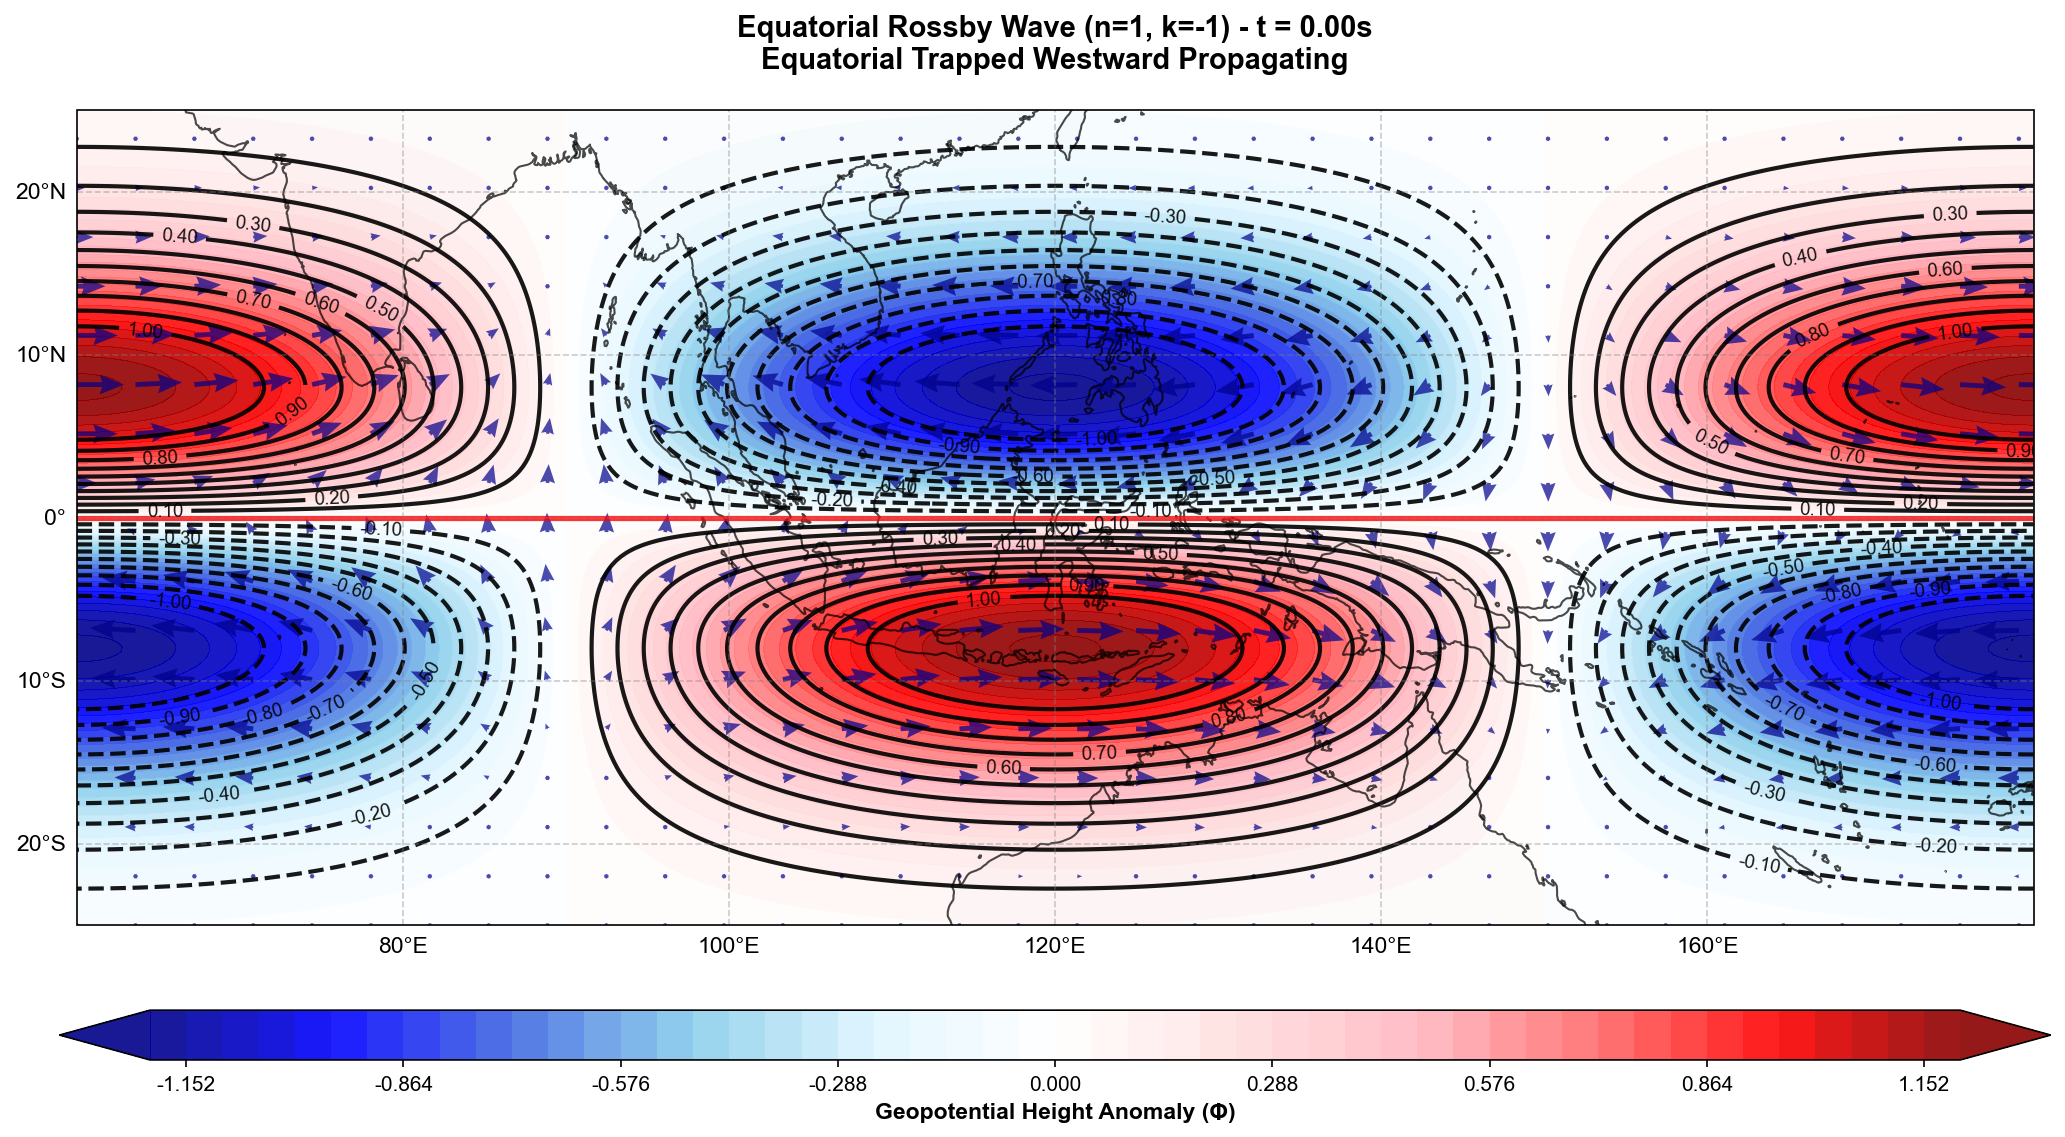


[2] Rossby波 3D
✓ 3D快照已保存: rossby_wave_3d_snapshot.png
✓ 3D快照已保存: rossby_wave_3d_snapshot.png


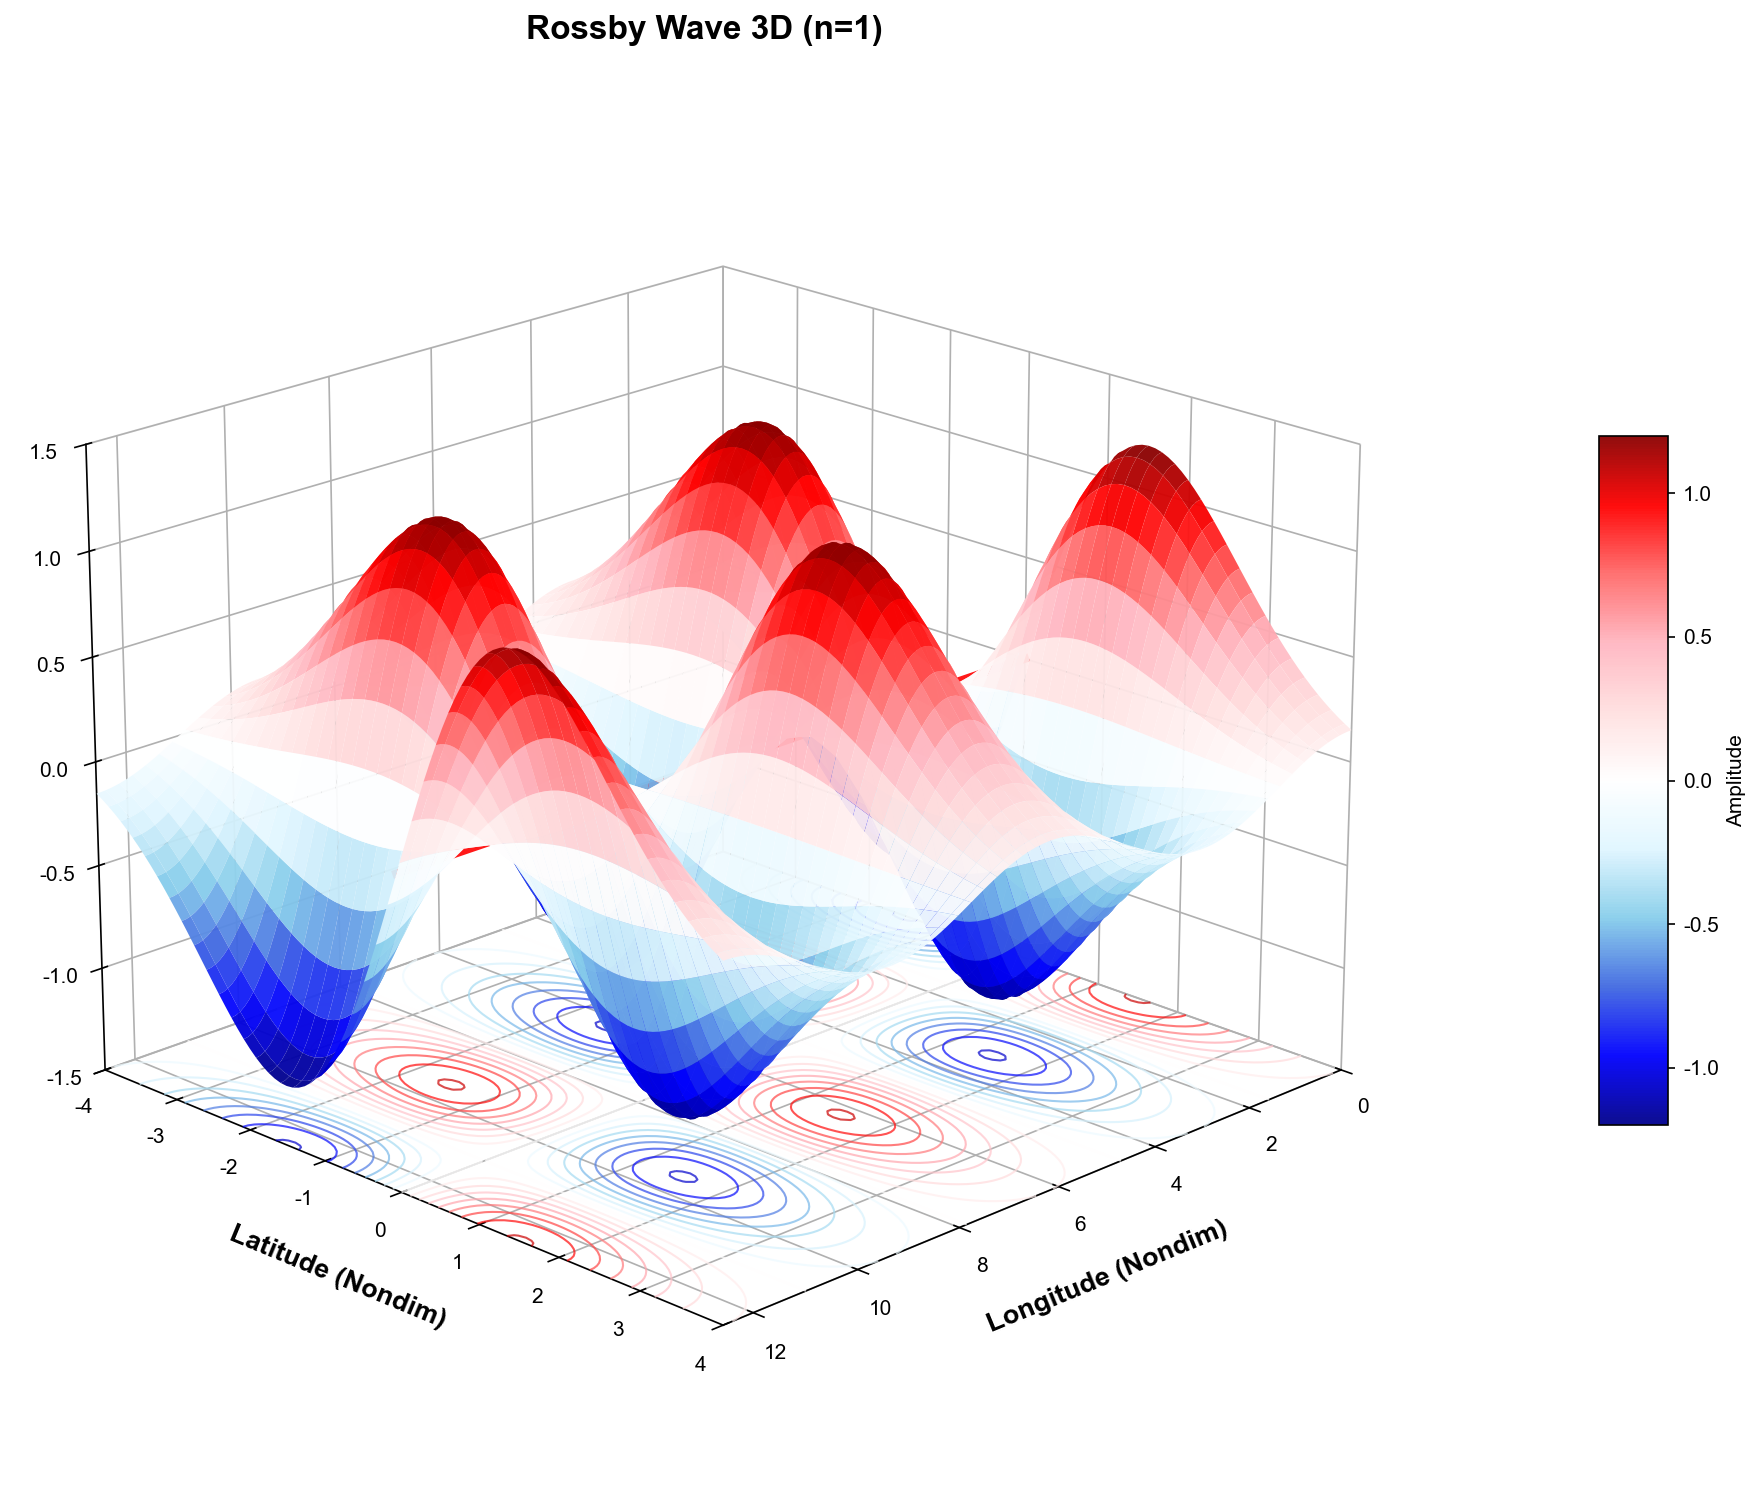


[3] MRG波 (混合Rossby-重力波)
✓ 2D快照已保存: mrg_wave_2d_snapshot.png
✓ 2D快照已保存: mrg_wave_2d_snapshot.png


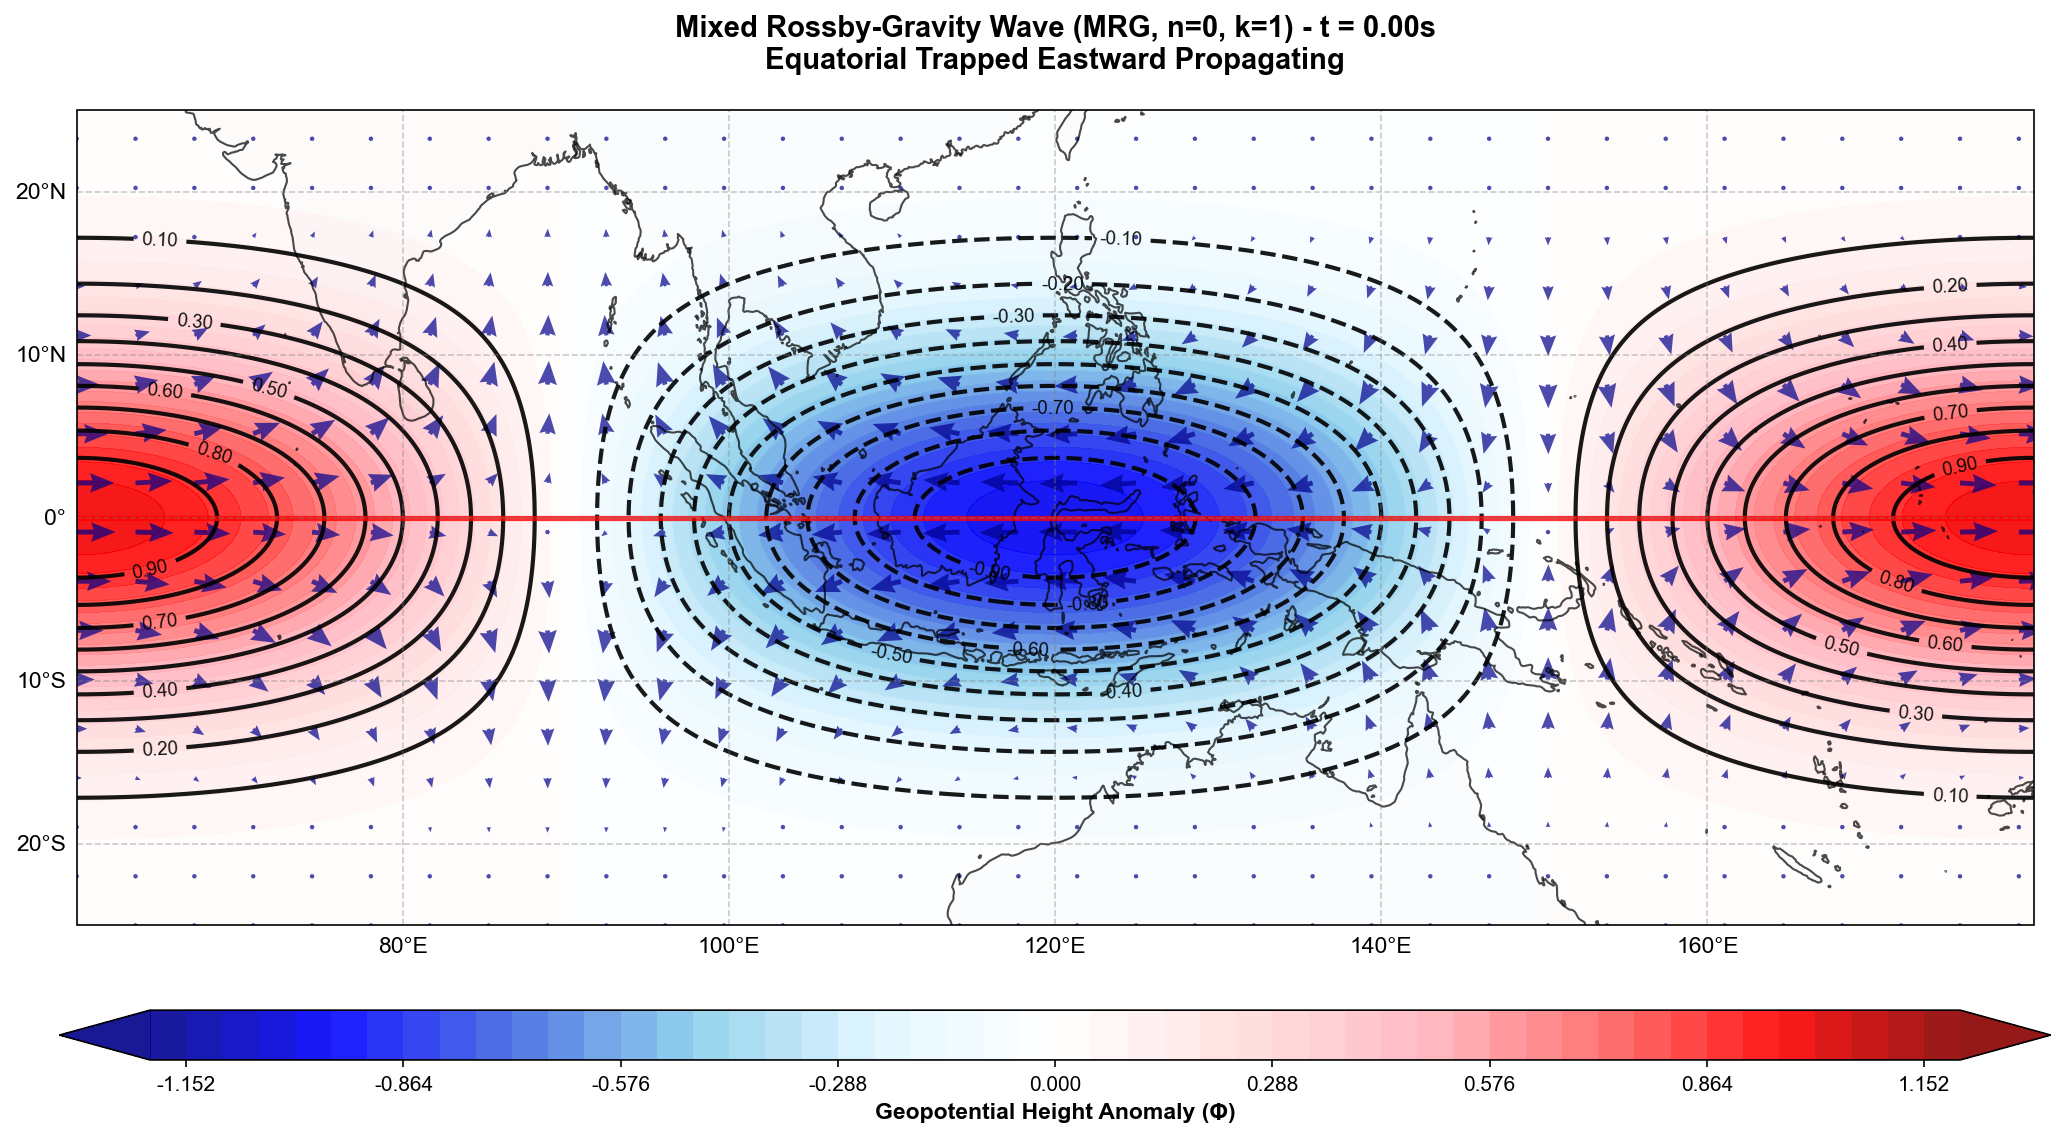


[4] MRG波 3D
✓ 3D快照已保存: mrg_wave_3d_snapshot.png
✓ 3D快照已保存: mrg_wave_3d_snapshot.png


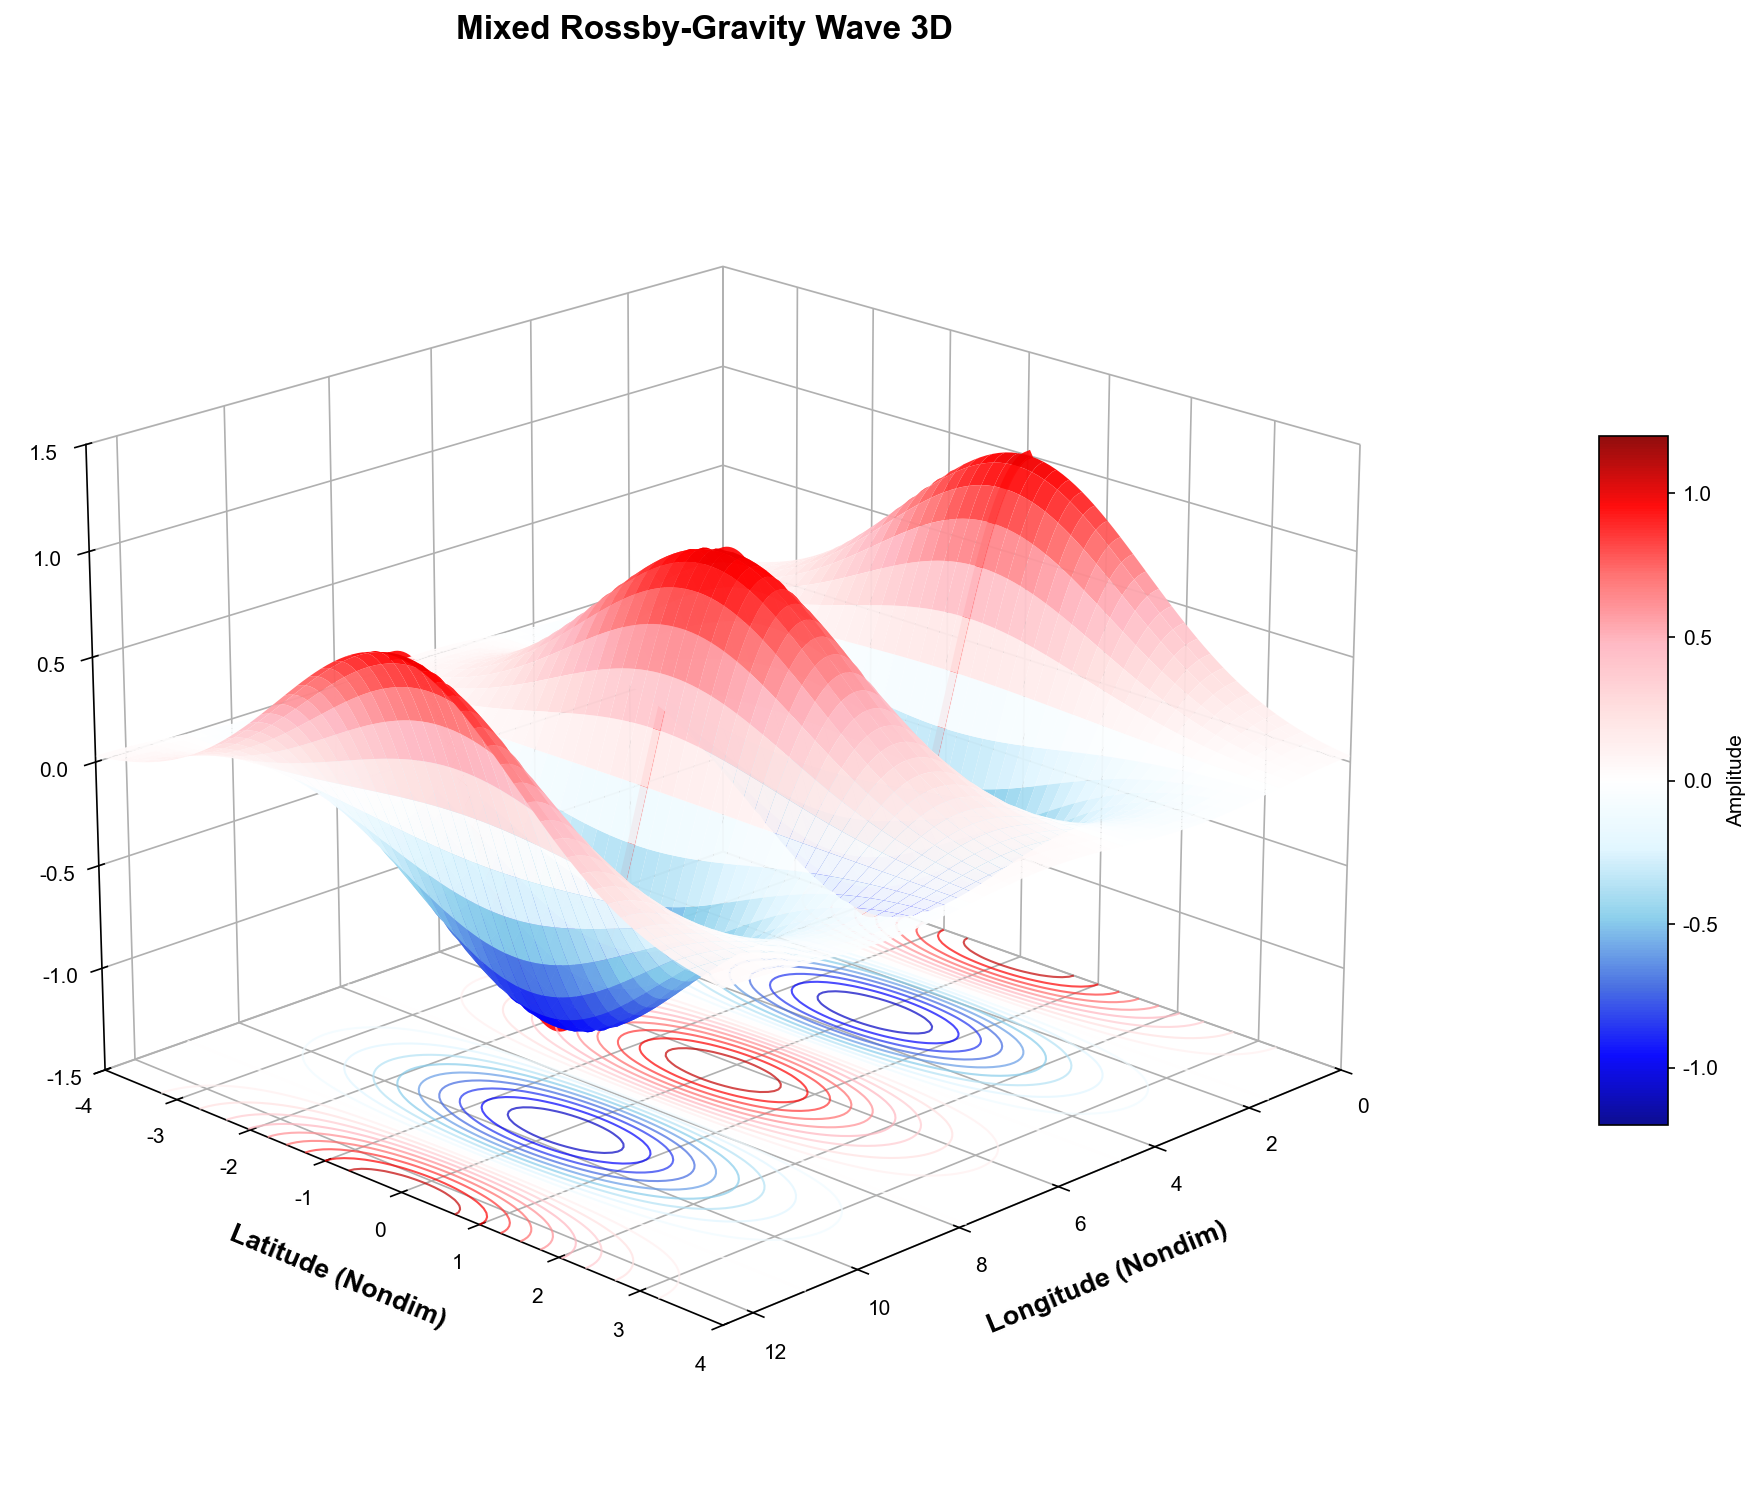


[5] 惯性重力波 (东传)
✓ 2D快照已保存: ig_east_wave_2d_snapshot.png
✓ 2D快照已保存: ig_east_wave_2d_snapshot.png


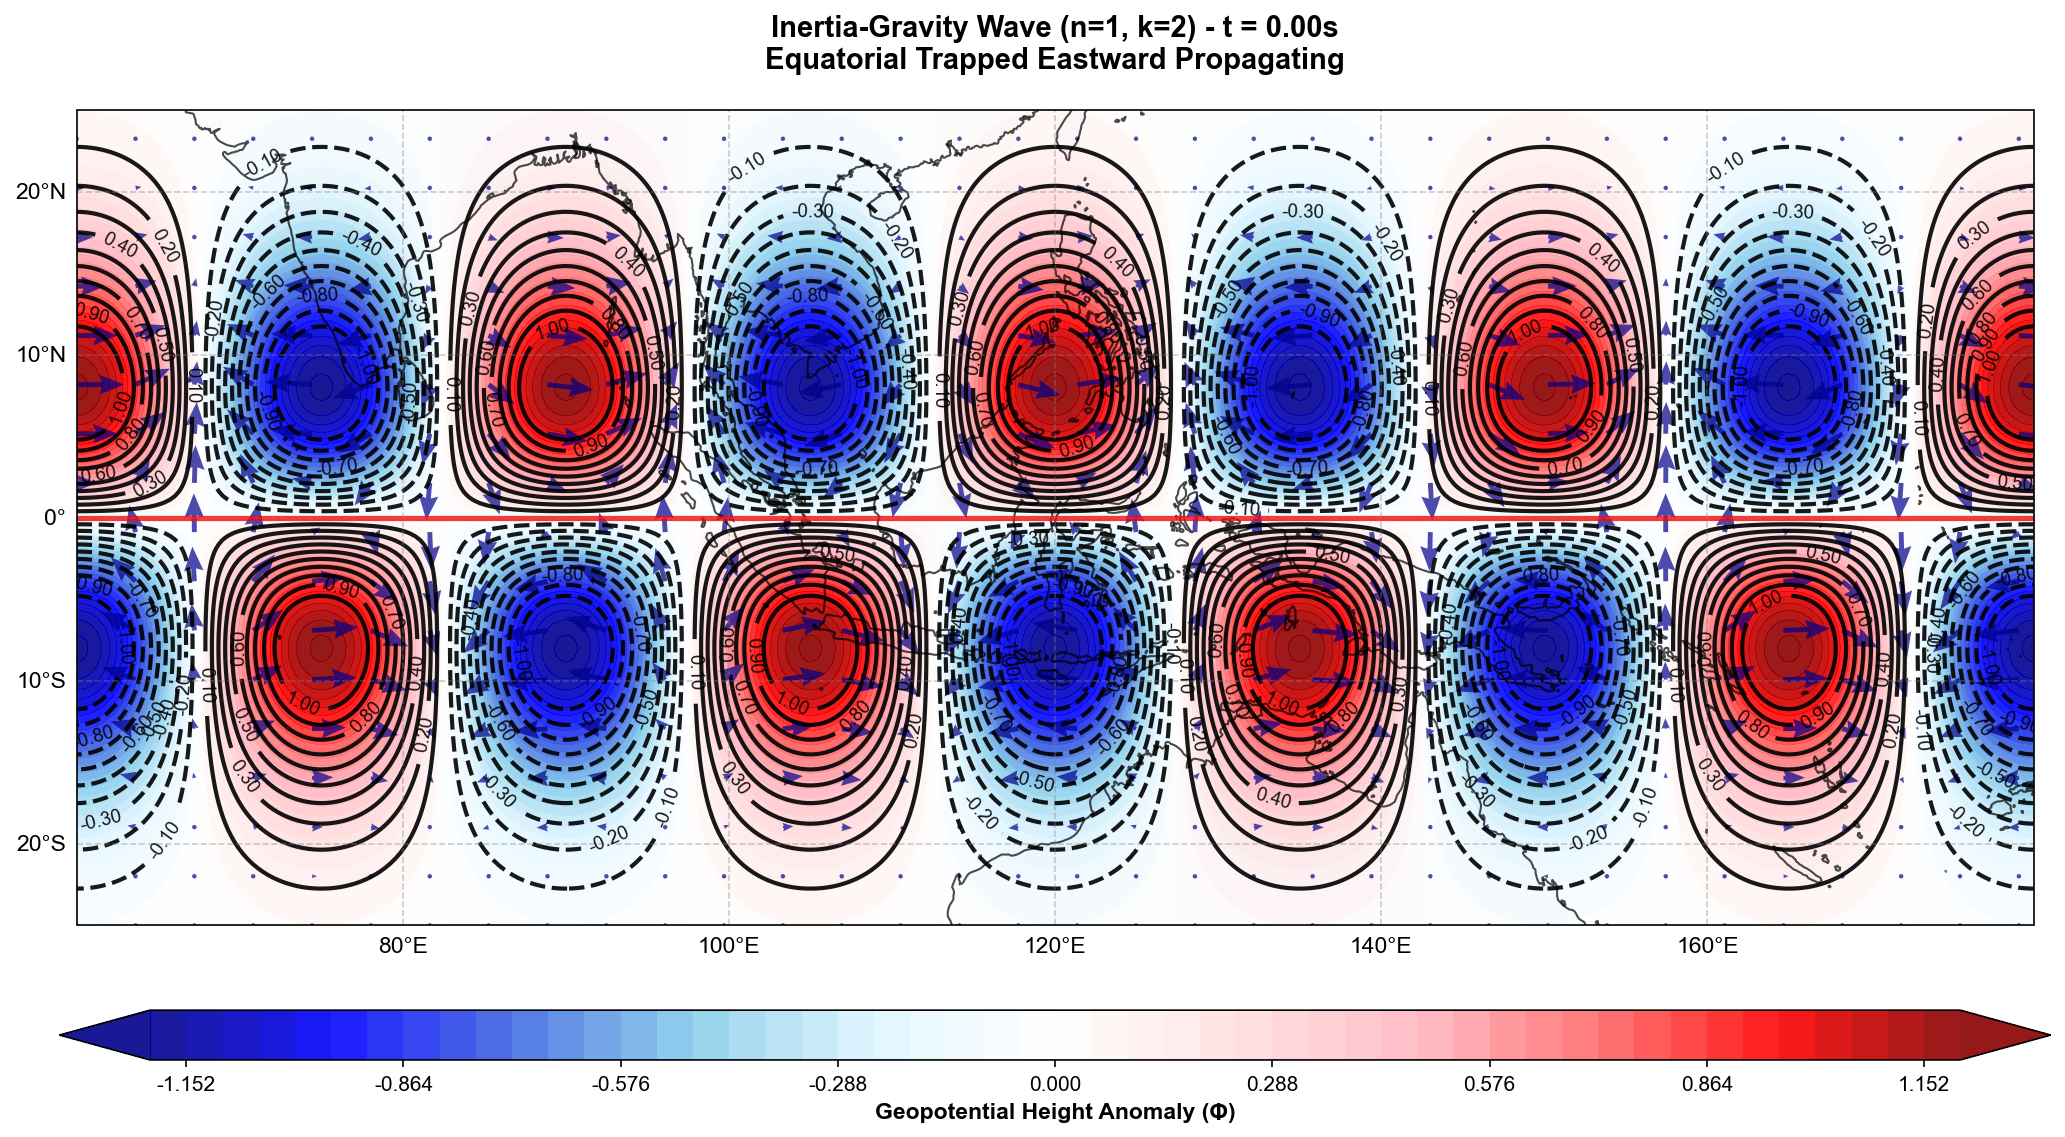


[6] 惯性重力波 3D (东传)
✓ 3D快照已保存: ig_east_wave_3d_snapshot.png
✓ 3D快照已保存: ig_east_wave_3d_snapshot.png


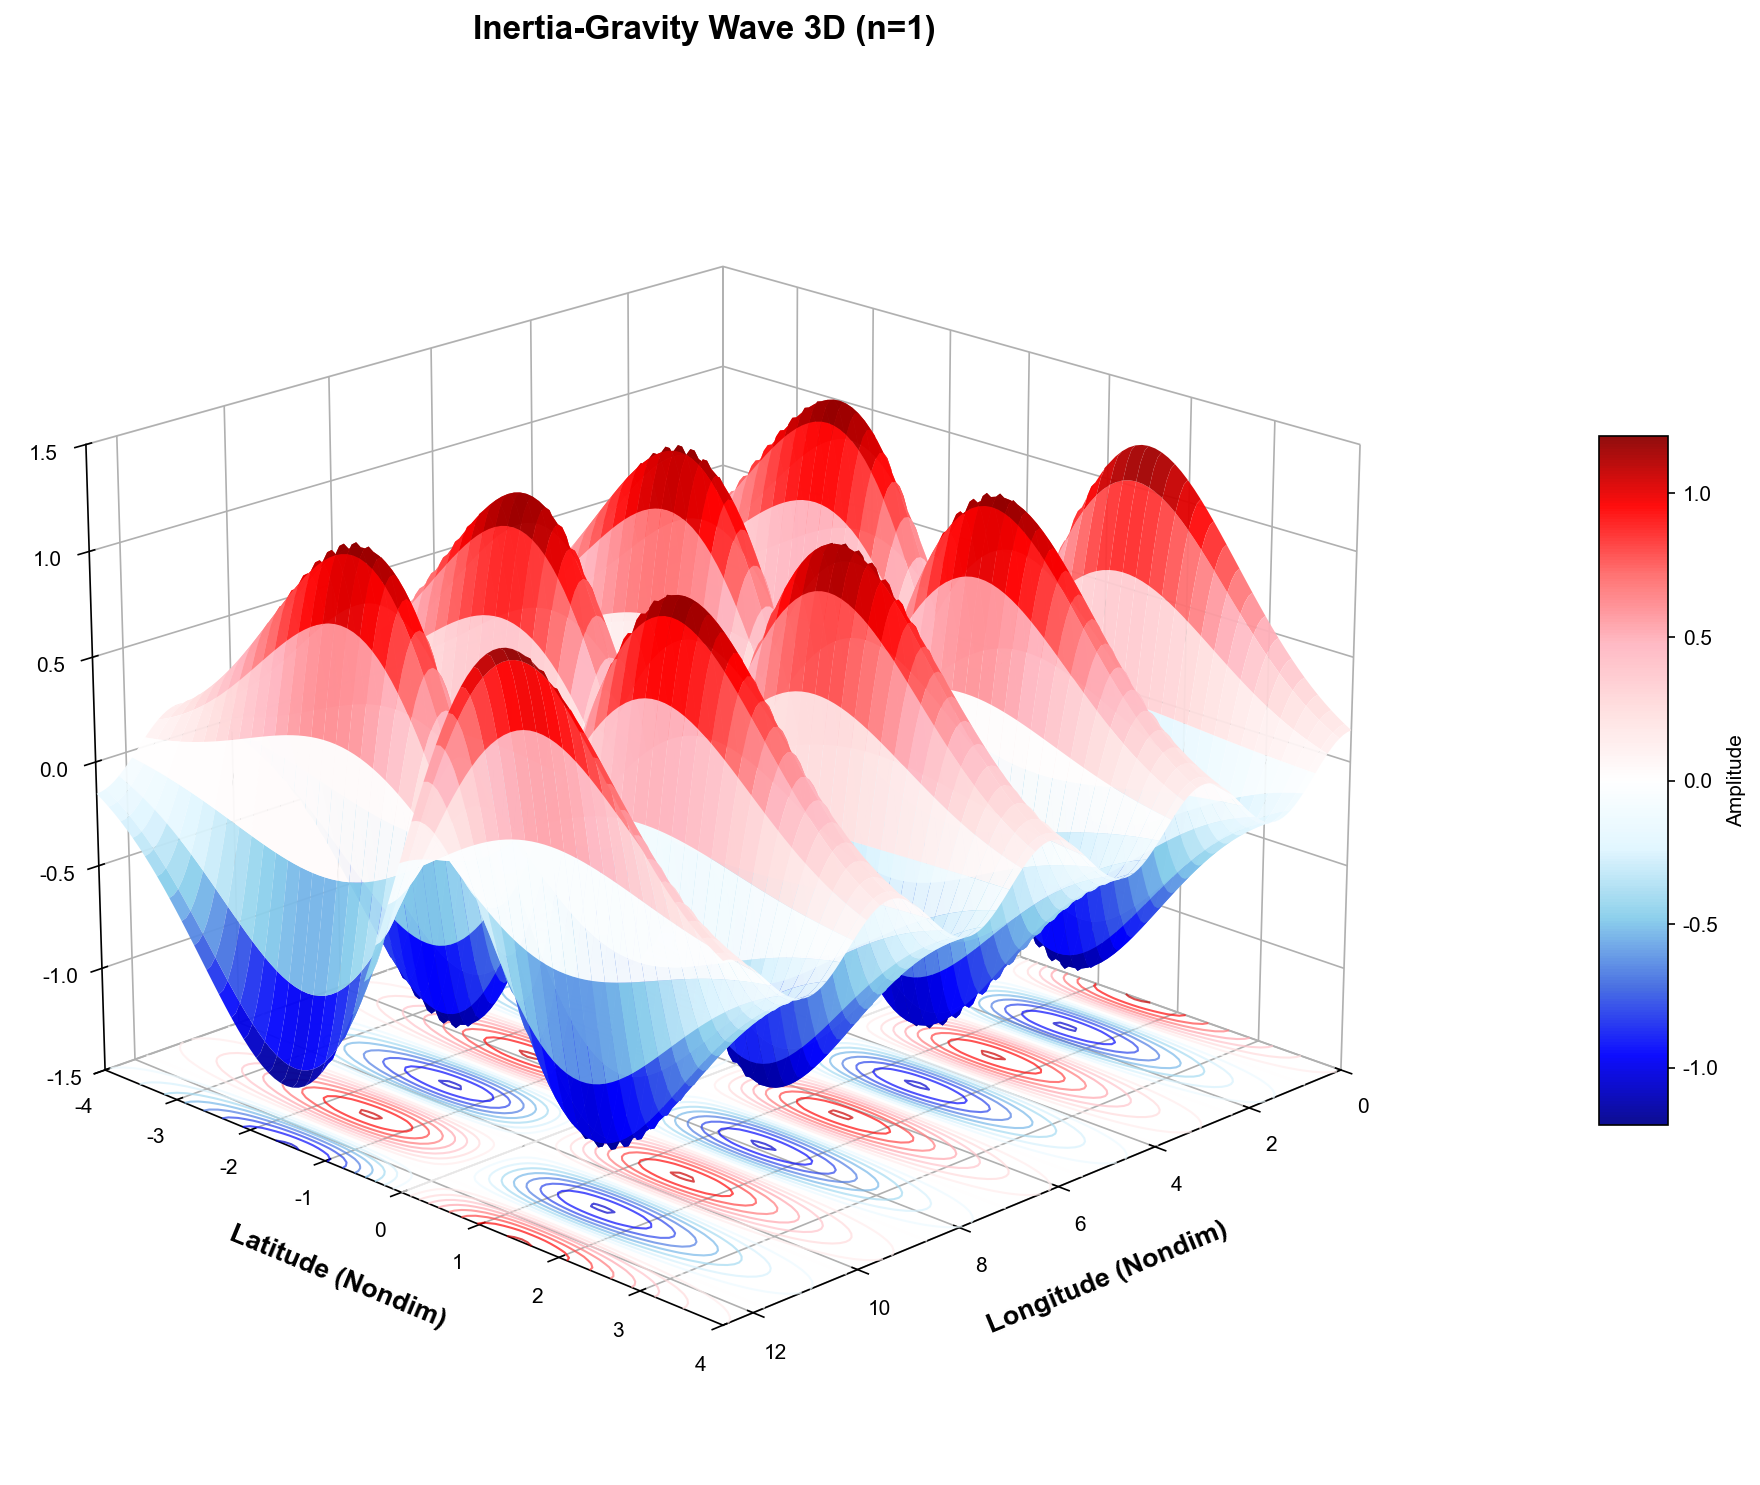


完成!


In [9]:
# -*- coding: utf-8 -*-
"""
赤道波动综合可视化 - Rossby波、混合Rossby-重力波、惯性重力波
包含2D平面图和3D立体图
"""
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import hermite

plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def create_colormap():
    """创建配色方案"""
    colors = ['#00008B', '#0000FF', '#4169E1', '#87CEEB', '#E0F6FF',
              '#FFFFFF', 
              '#FFE0E0', '#FFB6C1', '#FF6B6B', '#FF0000', '#8B0000']
    return LinearSegmentedColormap.from_list('wave_cmap', colors, N=256)

# ==================== 赤道波动理论解 ====================

def hermite_function(n, y):
    """
    计算Hermite函数 (归一化的Hermite多项式)
    
    参数:
        n: 模态数
        y: 无量纲纬度坐标
    """
    H_n = hermite(n)
    return H_n(y) * np.exp(-0.5 * y**2)

def rossby_wave_field(x, y, t, n=1, k=-1.0, omega=None, y_scale=1.5):
    """
    赤道Rossby波 (西传)
    
    参数:
        x, y: 空间坐标
        t: 时间
        n: 经向模态数 (n >= 1)
        k: 波数 (负值表示西传)
        omega: 频率 (如果为None，使用色散关系)
        y_scale: 纬度尺度
    """
    # Rossby波色散关系: omega = -beta*k / (k^2 + (2n+1))
    if omega is None:
        omega = -k / (k**2 + (2*n + 1))
    
    # 纬度结构
    y_scaled = y / y_scale
    y_structure = hermite_function(n, y_scaled)
    
    # 西传的波动相位
    phase = k * x - omega * t
    
    # 位势高度场
    Phi = y_structure * np.cos(phase)
    
    # 速度场
    u = y_structure * np.cos(phase)
    
    # 经向速度（Rossby波有南北运动）
    if n > 0:
        v = -0.5 * hermite_function(n-1, y_scaled) * np.sin(phase)
    else:
        v = np.zeros_like(u)
    
    return u, v, Phi

def mixed_rossby_gravity_wave_field(x, y, t, k=1.0, omega=None, y_scale=1.5):
    """
    混合Rossby-重力波 (MRG波, n=0模态)
    
    特点: 低频时为Rossby波性质，高频时为重力波性质
    """
    # MRG波色散关系: omega^2 - k*omega - k^2 = 0
    if omega is None:
        # 取正根（东传分支）
        omega = (k + np.sqrt(k**2 + 4*k**2)) / 2
    
    y_scaled = y / y_scale
    
    # n=0 Hermite函数
    y_structure = hermite_function(0, y_scaled)
    
    # 相位
    phase = k * x - omega * t
    
    # 位势高度场
    Phi = y_structure * np.cos(phase)
    
    # 速度场
    u = y_structure * np.cos(phase)
    v = y_structure * np.sin(phase) * y_scaled
    
    return u, v, Phi

def inertia_gravity_wave_field(x, y, t, n=1, k=2.0, omega=None, y_scale=1.5):
    """
    惯性重力波 (高频东传或西传)
    
    参数:
        n: 经向模态数 (n >= 1)
        k: 波数 (正为东传，负为西传)
        omega: 频率 (高频)
    """
    # 惯性重力波色散关系: omega^2 = k^2 + (2n+1)
    if omega is None:
        omega = np.sqrt(k**2 + (2*n + 1))
        if k < 0:
            omega = -omega  # 西传
    
    y_scaled = y / y_scale
    y_structure = hermite_function(n, y_scaled)
    
    phase = k * x - omega * t
    
    # 位势高度场
    Phi = y_structure * np.cos(phase)
    
    # 速度场
    u = y_structure * np.cos(phase)
    
    # 经向速度
    if n > 0:
        v = hermite_function(n-1, y_scaled) * np.sin(phase)
    else:
        v = np.zeros_like(u)
    
    return u, v, Phi

# ==================== 2D可视化函数 ====================

def plot_equatorial_wave_2d(
        wave_type='rossby',
        lon_range=(60, 180),
        lat_range=(-25, 25),
        t=0.0,
        wave_number=1,
        mode_n=1,
        save_path=None):
    """
    绘制赤道波动2D快照
    
    参数:
        wave_type: 'rossby', 'mrg', 'ig_east', 'ig_west'
        mode_n: 经向模态数
    """
    
    nx, ny = 400, 200
    lon = np.linspace(lon_range[0], lon_range[1], nx)
    lat = np.linspace(lat_range[0], lat_range[1], ny)
    LON, LAT = np.meshgrid(lon, lat)
    
    # 物理空间坐标
    x_phys = np.linspace(0, 2*np.pi*abs(wave_number), nx)
    y_phys = np.linspace(lat_range[0], lat_range[1], ny)
    X, Y = np.meshgrid(x_phys, y_phys)
    
    # 根据波类型计算场
    if wave_type == 'rossby':
        k = -abs(wave_number)  # Rossby波西传
        u, v, Phi = rossby_wave_field(X, Y, t, n=mode_n, k=k, y_scale=8.0)
        title = f'Equatorial Rossby Wave (n={mode_n}, k={k})'
        direction = 'Westward Propagating'
    elif wave_type == 'mrg':
        k = wave_number
        u, v, Phi = mixed_rossby_gravity_wave_field(X, Y, t, k=k, y_scale=8.0)
        title = f'Mixed Rossby-Gravity Wave (MRG, n=0, k={k})'
        direction = 'Eastward Propagating'
    elif wave_type == 'ig_east':
        k = abs(wave_number)
        u, v, Phi = inertia_gravity_wave_field(X, Y, t, n=mode_n, k=k, y_scale=8.0)
        title = f'Inertia-Gravity Wave (n={mode_n}, k={k})'
        direction = 'Eastward Propagating'
    elif wave_type == 'ig_west':
        k = -abs(wave_number)
        u, v, Phi = inertia_gravity_wave_field(X, Y, t, n=mode_n, k=k, y_scale=8.0)
        title = f'Inertia-Gravity Wave (n={mode_n}, k={k})'
        direction = 'Westward Propagating'
    else:
        raise ValueError("wave_type must be 'rossby', 'mrg', 'ig_east', or 'ig_west'")
    
    cmap = create_colormap()
    projection = ccrs.PlateCarree()
    
    fig = plt.figure(figsize=(18, 8), dpi=150)
    ax = fig.add_subplot(111, projection=projection)
    
    # 地图背景
    ax.coastlines(resolution='50m', linewidth=1, color='black', alpha=0.7)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3,
                  edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='white', alpha=0.2)
    
    # 填色
    levels_fill = np.linspace(-1.2, 1.2, 51)
    cf = ax.contourf(LON, LAT, Phi, levels=levels_fill, cmap=cmap,
                    extend='both', transform=projection, alpha=0.9)
    
    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal',
                       pad=0.08, shrink=0.75, aspect=40)
    cbar.set_label('Geopotential Height Anomaly (Φ)', fontsize=11, fontweight='bold')
    
    # 等值线
    levels_contour = np.linspace(-1.0, 1.0, 21)
    cs_pos = ax.contour(LON, LAT, Phi, levels=levels_contour[levels_contour > 0],
                       colors='black', linewidths=2, transform=projection, alpha=0.9)
    cs_neg = ax.contour(LON, LAT, Phi, levels=levels_contour[levels_contour < 0],
                       colors='black', linewidths=2, linestyles='dashed',
                       transform=projection, alpha=0.9)
    
    ax.clabel(cs_pos, inline=True, fontsize=9, fmt='%.2f', inline_spacing=10)
    ax.clabel(cs_neg, inline=True, fontsize=9, fmt='%.2f', inline_spacing=10)
    
    # 风矢量
    step = 12
    Q = ax.quiver(LON[::step, ::step], LAT[::step, ::step],
                 u[::step, ::step], v[::step, ::step],
                 scale=50, color='darkblue', alpha=0.7, 
                 transform=projection, headwidth=4, headlength=5)
    
    # 赤道
    ax.plot([lon_range[0], lon_range[1]], [0, 0], 
            color='red', linewidth=2.5, linestyle='-', 
            alpha=0.8, transform=projection)
    
    # 地图设置
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]],
                 crs=projection)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.8,
                     color='gray', alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 11}
    gl.ylabel_style = {'size': 11}
    
    # 标题
    ax.set_title(
        f'{title} - t = {t:.2f}s\n'
        f'Equatorial Trapped {direction}',
        fontsize=14, fontweight='bold', pad=20
    )
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ 2D快照已保存: {save_path}")
    
    plt.show()
    return fig, ax

# ==================== 2D动画函数 ====================

def create_equatorial_wave_2d_animation(
        wave_type='rossby',
        lon_range=(60, 180),
        lat_range=(-25, 25),
        nx=300, ny=150,
        total_frames=60,
        wave_number=1,
        mode_n=1,
        save_path=None):
    """
    创建赤道波动2D动画
    """
    
    # 空间网格
    lon = np.linspace(lon_range[0], lon_range[1], nx)
    lat = np.linspace(lat_range[0], lat_range[1], ny)
    LON, LAT = np.meshgrid(lon, lat)
    
    x_phys = np.linspace(0, 2*np.pi*abs(wave_number), nx)
    y_phys = np.linspace(lat_range[0], lat_range[1], ny)
    X, Y = np.meshgrid(x_phys, y_phys)
    
    # 预计算所有帧
    print(f"预计算 {total_frames} 帧 {wave_type} 波数据...")
    frames_data = []
    
    for frame in range(total_frames):
        t = frame * 2 * np.pi / total_frames
        
        if wave_type == 'rossby':
            k = -abs(wave_number)
            u, v, Phi = rossby_wave_field(X, Y, t, n=mode_n, k=k, y_scale=8.0)
            wave_name = f'Rossby (n={mode_n})'
            direction = 'West ← East'
        elif wave_type == 'mrg':
            k = wave_number
            u, v, Phi = mixed_rossby_gravity_wave_field(X, Y, t, k=k, y_scale=8.0)
            wave_name = 'MRG (n=0)'
            direction = 'West → East'
        elif wave_type == 'ig_east':
            k = abs(wave_number)
            u, v, Phi = inertia_gravity_wave_field(X, Y, t, n=mode_n, k=k, y_scale=8.0)
            wave_name = f'IG East (n={mode_n})'
            direction = 'West → East'
        elif wave_type == 'ig_west':
            k = -abs(wave_number)
            u, v, Phi = inertia_gravity_wave_field(X, Y, t, n=mode_n, k=k, y_scale=8.0)
            wave_name = f'IG West (n={mode_n})'
            direction = 'West ← East'
        
        frames_data.append({'u': u, 'v': v, 'Phi': Phi, 't': t, 
                          'name': wave_name, 'direction': direction})
    
    print("开始渲染2D动画...")
    
    # 创建图形
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(16, 9), dpi=120)
    ax = fig.add_subplot(111, projection=projection)
    fig.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.08)
    
    cmap = create_colormap()
    
    def animate(frame):
        ax.clear()
        
        data = frames_data[frame]
        u, v, Phi = data['u'], data['v'], data['Phi']
        
        # 地图背景
        ax.coastlines(resolution='110m', linewidth=0.8, color='black', alpha=0.6)
        ax.add_feature(cfeature.LAND, facecolor='white', alpha=0.3)
        
        # 填色
        levels_fill = np.linspace(-1.2, 1.2, 31)
        cf = ax.contourf(LON, LAT, Phi, levels=levels_fill, 
                        cmap=cmap, extend='both', 
                        transform=projection, alpha=0.85)
        
        # 等值线
        levels_contour = np.linspace(-1.0, 1.0, 11)
        cs_solid = ax.contour(LON, LAT, Phi, 
                             levels=levels_contour[levels_contour > 0], 
                             colors='black', linewidths=1.5, 
                             transform=projection, alpha=0.8)
        cs_dashed = ax.contour(LON, LAT, Phi, 
                              levels=levels_contour[levels_contour < 0], 
                              colors='black', linewidths=1.5, 
                              linestyles='dashed',
                              transform=projection, alpha=0.8)
        
        ax.clabel(cs_solid, inline=True, fontsize=8, fmt='%.2f')
        ax.clabel(cs_dashed, inline=True, fontsize=8, fmt='%.2f')
        
        # 风矢量
        step = 12
        Q = ax.quiver(LON[::step, ::step], LAT[::step, ::step],
                     u[::step, ::step], v[::step, ::step],
                     scale=50, color='darkblue', alpha=0.7, 
                     transform=projection, headwidth=4, headlength=5)
        
        # 赤道
        ax.plot([lon_range[0], lon_range[1]], [0, 0], 
                color='red', linewidth=2, linestyle='-', 
                alpha=0.7, transform=projection)
        
        # 地图设置
        ax.set_extent([lon_range[0], lon_range[1], 
                      lat_range[0], lat_range[1]], crs=projection)
        
        gl = ax.gridlines(draw_labels=True, linewidth=0.75, 
                         color='gray', alpha=0.3, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 12}
        gl.ylabel_style = {'size': 12}
        
        # 标题
        phase_deg = (frame / total_frames) * 360
        ax.set_title(
            f'{data["name"]} Wave - {data["direction"]}\n'
            f'Time: {data["t"]:.2f}s | Phase: {phase_deg:.1f}° | Frame: {frame+1}/{total_frames}',
            fontsize=13, fontweight='bold', pad=15
        )
        
        return [cf]
    
    anim = animation.FuncAnimation(fig, animate, frames=total_frames,
                                  interval=100, blit=False, repeat=True)
    
    if save_path:
        print(f"保存2D动画到 {save_path}...")
        try:
            anim.save(save_path, writer='pillow', fps=10, dpi=100)
            print(f"✓ 成功保存!")
        except Exception as e:
            print(f"✗ 保存失败: {e}")
    
    return fig, anim

# ==================== 3D可视化函数 ====================

def plot_equatorial_wave_3d(
        wave_type='rossby',
        x_range=(0, 4*np.pi),
        y_range=(-4, 4),
        t=0.0,
        wave_number=1,
        mode_n=1,
        elevation=20,
        azimuth=45,
        save_path=None):
    """
    绘制赤道波动3D快照
    """
    
    nx, ny = 150, 100
    x = np.linspace(x_range[0], x_range[1], nx)
    y = np.linspace(y_range[0], y_range[1], ny)
    X, Y = np.meshgrid(x, y)
    
    # 计算波场
    if wave_type == 'rossby':
        k = -abs(wave_number)
        _, _, Z = rossby_wave_field(X, Y, t, n=mode_n, k=k, y_scale=1.5)
        title = f'Rossby Wave 3D (n={mode_n})'
    elif wave_type == 'mrg':
        k = wave_number
        _, _, Z = mixed_rossby_gravity_wave_field(X, Y, t, k=k, y_scale=1.5)
        title = 'Mixed Rossby-Gravity Wave 3D'
    elif wave_type == 'ig_east':
        k = abs(wave_number)
        _, _, Z = inertia_gravity_wave_field(X, Y, t, n=mode_n, k=k, y_scale=1.5)
        title = f'Inertia-Gravity Wave 3D (n={mode_n})'
    elif wave_type == 'ig_west':
        k = -abs(wave_number)
        _, _, Z = inertia_gravity_wave_field(X, Y, t, n=mode_n, k=k, y_scale=1.5)
        title = f'Inertia-Gravity Wave 3D (n={mode_n})'
    
    cmap = create_colormap()
    
    fig = plt.figure(figsize=(14, 10), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    
    # 3D曲面
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, 
                          alpha=0.95, linewidth=0, 
                          antialiased=True,
                          vmin=-1.2, vmax=1.2)
    
    # 底部投影
    contour = ax.contour(X, Y, Z, levels=20, 
                        cmap=cmap, linewidths=1.0, 
                        offset=-1.5, alpha=0.7)
    
    # 赤道线
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = np.zeros_like(x_line)
    
    if wave_type == 'rossby':
        k = -abs(wave_number)
        _, _, z_line = rossby_wave_field(x_line, y_line, t, n=mode_n, k=k, y_scale=1.5)
    elif wave_type == 'mrg':
        k = wave_number
        _, _, z_line = mixed_rossby_gravity_wave_field(x_line, y_line, t, k=k, y_scale=1.5)
    elif wave_type in ['ig_east', 'ig_west']:
        k = abs(wave_number) if wave_type == 'ig_east' else -abs(wave_number)
        _, _, z_line = inertia_gravity_wave_field(x_line, y_line, t, n=mode_n, k=k, y_scale=1.5)
    
    ax.plot(x_line, y_line, z_line, 
           color='red', linewidth=4, alpha=0.9, label='Equator')
    
    # 坐标轴
    ax.set_xlabel('Longitude (Nondim)', fontsize=13, fontweight='bold', labelpad=12)
    ax.set_ylabel('Latitude (Nondim)', fontsize=13, fontweight='bold', labelpad=12)
    ax.set_zlabel('Amplitude (Nondim)', fontsize=13, fontweight='bold', labelpad=12)
    
    ax.set_xlim(x_range[0], x_range[1])
    ax.set_ylim(y_range[0], y_range[1])
    ax.set_zlim(-1.5, 1.5)
    
    ax.view_init(elev=elevation, azim=azimuth)
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=25)
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, 
                pad=0.1, label='Amplitude')
    
    ax.grid(True, alpha=0.3)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ 3D快照已保存: {save_path}")
    
    plt.show()
    return fig, ax

# ==================== 测试代码 ====================

if __name__ == '__main__':
    print("=" * 70)
    print("赤道波动综合可视化程序")
    print("=" * 70)
    
    # ===== Rossby波 =====
    print("\n[1] Rossby波 (西传)")
    plot_equatorial_wave_2d(
        wave_type='rossby',
        lon_range=(60, 180),
        lat_range=(-25, 25),
        t=0.0,
        wave_number=1,
        mode_n=1,
        save_path='rossby_wave_2d_snapshot.png'
    )
    
    print("\n[2] Rossby波 3D")
    plot_equatorial_wave_3d(
        wave_type='rossby',
        wave_number=1,
        mode_n=1,
        elevation=20,
        azimuth=45,
        save_path='rossby_wave_3d_snapshot.png'
    )
    
    # ===== 混合Rossby-重力波 =====
    print("\n[3] MRG波 (混合Rossby-重力波)")
    plot_equatorial_wave_2d(
        wave_type='mrg',
        lon_range=(60, 180),
        lat_range=(-25, 25),
        t=0.0,
        wave_number=1,
        save_path='mrg_wave_2d_snapshot.png'
    )
    
    print("\n[4] MRG波 3D")
    plot_equatorial_wave_3d(
        wave_type='mrg',
        wave_number=1,
        elevation=20,
        azimuth=45,
        save_path='mrg_wave_3d_snapshot.png'
    )
    
    # ===== 惯性重力波 (东传) =====
    print("\n[5] 惯性重力波 (东传)")
    plot_equatorial_wave_2d(
        wave_type='ig_east',
        lon_range=(60, 180),
        lat_range=(-25, 25),
        t=0.0,
        wave_number=2,
        mode_n=1,
        save_path='ig_east_wave_2d_snapshot.png'
    )
    
    print("\n[6] 惯性重力波 3D (东传)")
    plot_equatorial_wave_3d(
        wave_type='ig_east',
        wave_number=2,
        mode_n=1,
        elevation=20,
        azimuth=45,
        save_path='ig_east_wave_3d_snapshot.png'
    )
    
    # ===== 生成动画示例 (取消注释以生成) =====
    # print("\n[7] 生成Rossby波动画...")
    # create_equatorial_wave_2d_animation(
    #     wave_type='rossby',
    #     wave_number=1,
    #     mode_n=1,
    #     total_frames=60,
    #     save_path='rossby_wave_animation.gif'
    # )
    
    # print("\n[8] 生成MRG波动画...")
    # create_equatorial_wave_2d_animation(
    #     wave_type='mrg',
    #     wave_number=1,
    #     total_frames=60,
    #     save_path='mrg_wave_animation.gif'
    # )
    
    print("\n完成!")